# **Klasifikasi Gerakan untuk Rehabilitasi Stroke Menggunakan LSTM**
Dataset yang akan digunakan adalah 10 video gerakan rehabilitasi untuk pasien stroke yang ditemukan di Internet.

Proyek ini bertujuan untuk mendeteksi gerakan ....

# **1. Import Library**

In [12]:
import os
import cv2
import pandas as pd
import numpy as np
import time
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import defaultdict, deque
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from ultralytics import YOLO
from sklearn.preprocessing import StandardScaler

# **2. Memuat Dataset**

In [13]:
# --- 2. Memuat Dataset ---
# Setup Folders for Collection
ORIGINAL_VIDEO_DIR = 'dataset_video' # Direktori video asli
AUGMENTED_VIDEO_DIR = 'dataset_video_augmented' # Direktori untuk menyimpan video yang diaugmentasi
sequence_length = 60         # frame per sequence (akan di-resample ke sini) - DIUBAH DARI 30 MENJADI 60
RANDOM_SEED     = 42

# Definisi Aksi Utama dan Sub-label
BASE_ACTIONS = sorted([d for d in os.listdir(ORIGINAL_VIDEO_DIR)
                  if os.path.isdir(os.path.join(ORIGINAL_VIDEO_DIR,d))])
SUB_LABELS = ["Tidak Bergerak", "Tidak Sempurna", "Sempurna"]

# Buat daftar lengkap label untuk model (misal: "Angkat Tangan - Tidak Bergerak")
FULL_ACTIONS = []
for base_action in BASE_ACTIONS:
    for sub_label in SUB_LABELS:
        FULL_ACTIONS.append(f"{base_action} - {sub_label}")

print('Kelas Utama Terdeteksi:', BASE_ACTIONS)
print('Sub-label Gerakan:', SUB_LABELS)
print('Total Kelas Model (Gabungan):', FULL_ACTIONS, '\n')


vid_dict = defaultdict(list)   # {action: [video_path, …]}
for act in BASE_ACTIONS: # Menggunakan BASE_ACTIONS untuk memuat video
    for f in sorted(os.listdir(os.path.join(ORIGINAL_VIDEO_DIR,act))):
        if f.lower().endswith(('.mp4','.mov','.avi','.mkv')):\
            vid_dict[act].append(os.path.join(ORIGINAL_VIDEO_DIR,act,f))

Kelas Utama Terdeteksi: ['Angkat Pinggul', 'Angkat Tangan', 'Lutut Turun', 'Naikan Kepalan Kedepan', 'Rentangkan']
Sub-label Gerakan: ['Tidak Bergerak', 'Tidak Sempurna', 'Sempurna']
Total Kelas Model (Gabungan): ['Angkat Pinggul - Tidak Bergerak', 'Angkat Pinggul - Tidak Sempurna', 'Angkat Pinggul - Sempurna', 'Angkat Tangan - Tidak Bergerak', 'Angkat Tangan - Tidak Sempurna', 'Angkat Tangan - Sempurna', 'Lutut Turun - Tidak Bergerak', 'Lutut Turun - Tidak Sempurna', 'Lutut Turun - Sempurna', 'Naikan Kepalan Kedepan - Tidak Bergerak', 'Naikan Kepalan Kedepan - Tidak Sempurna', 'Naikan Kepalan Kedepan - Sempurna', 'Rentangkan - Tidak Bergerak', 'Rentangkan - Tidak Sempurna', 'Rentangkan - Sempurna'] 



# **3. Exploratory Data Analysis (EDA)**

,action,video,fps,frames,duration
0,Angkat Pinggul,1.MOV,59.953704,259,4.320000
1,Angkat Pinggul,10.mp4,30.000000,104,3.466667
2,Angkat Pinggul,11.mp4,29.836711,153,5.127911
3,Angkat Pinggul,12.mp4,30.031600,134,4.461967
4,Angkat Pinggul,13.mp4,30.031612,114,3.796000
...,...,...,...,...,...
95,Rentangkan,5.MOV,29.971182,156,5.205000
96,Rentangkan,6.MOV,59.970312,202,3.368333
97,Rentangkan,7.mp4,30.000000,142,4.733333
98,Rentangkan,8.mp4,30.000000,155,5.166667


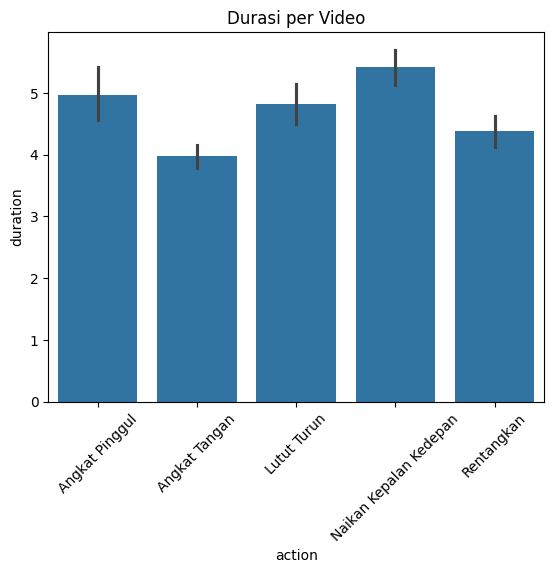

In [14]:
# --- 3. Exploratory Data Analysis (EDA) ---
rows=[]
for act in BASE_ACTIONS: # Menggunakan BASE_ACTIONS
    for vp in vid_dict[act]:
        cap=cv2.VideoCapture(vp)
        fps  = cap.get(cv2.CAP_PROP_FPS) or 30
        nfrm = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        dur  = nfrm/fps
        rows.append(dict(action=act, video=os.path.basename(vp),\
                         fps=fps, frames=nfrm, duration=dur))
        cap.release()
df=pd.DataFrame(rows)
display(df)
sns.barplot(data=df,x='action',y='duration')
plt.xticks(rotation=45); plt.title('Durasi per Video'); plt.show()


# **4. Preprocessing**

### Ekstraksi Keypoints


In [15]:
# --- 4. Preprocessing - a. Augmentasi Video (Memperlambat/Mempercepat) ---
print("\n--- Augmentasi Video (Memperlambat/Mempercepat) ---")

# Faktor kecepatan: 0.5x (setengah), 1.0x (asli), 1.5x (satu setengah)
VIDEO_SPEED_FACTORS = [0.5, 1.0, 1.5] 

os.makedirs(AUGMENTED_VIDEO_DIR, exist_ok=True)

for action in BASE_ACTIONS:
    original_action_dir = os.path.join(ORIGINAL_VIDEO_DIR, action)
    augmented_action_dir = os.path.join(AUGMENTED_VIDEO_DIR, action)
    os.makedirs(augmented_action_dir, exist_ok=True)

    for video_name in tqdm(os.listdir(original_action_dir), desc=f"Augmentasi {action} Videos"):
        video_path = os.path.join(original_action_dir, video_name)
        
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Gagal membuka video: {video_path}")
            continue

        original_fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        # Simpan semua frame ke memori untuk resampling yang lebih akurat
        frames_list = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frames_list.append(frame)
        cap.release()

        if not frames_list:
            print(f"Video kosong atau tidak ada frame: {video_path}")
            continue

        for speed_factor in VIDEO_SPEED_FACTORS:
            # Nama file augmented: original_name_speedX.mp4
            augmented_video_name = video_name.replace(".MOV", "").replace(".mp4", "") + f"_speed{str(speed_factor).replace('.', '')}.mp4"
            output_video_path = os.path.join(augmented_action_dir, augmented_video_name)

            # Hitung jumlah frame yang akan diambil untuk kecepatan baru
            # new_num_frames = int(len(frames_list) / speed_factor)
            # indices_for_resampling = np.linspace(0, len(frames_list) - 1, num=new_num_frames, dtype=int)
            
            # Gunakan FPS asli untuk VideoWriter, tetapi lewati/duplikasi frame
            # Ini adalah cara sederhana untuk mengubah kecepatan playback
            # Atau, bisa juga dengan mengubah FPS VideoWriter: new_fps = original_fps * speed_factor
            # Namun, mengubah FPS VideoWriter bisa menyebabkan masalah kompatibilitas atau kualitas.
            # Pendekatan yang lebih baik adalah mengontrol frame yang ditulis.

            # Menggunakan original_fps untuk VideoWriter, dan mengontrol frame skipping/duplication
            out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), original_fps, (width, height))
            
            if out.isOpened():
                for i in range(len(frames_list)):
                    # Jika speed_factor > 1 (mempercepat), lewati frame
                    if speed_factor > 1 and i % int(speed_factor) != 0:
                        continue
                    # Jika speed_factor < 1 (memperlambat), duplikasi frame
                    if speed_factor < 1:
                        for _ in range(int(1/speed_factor)):
                            out.write(frames_list[i])
                    else: # speed_factor >= 1
                        out.write(frames_list[i])
                out.release()
                print(f"✅ Video augmented disimpan: {output_video_path}")
            else:
                print(f"❌ Gagal membuka VideoWriter untuk: {output_video_path}")

# Setelah augmentasi video, ubah VIDEO_DIR ke direktori augmented
VIDEO_DIR = AUGMENTED_VIDEO_DIR 
print(f"\nVIDEO_DIR diubah menjadi: {VIDEO_DIR}")



--- Augmentasi Video (Memperlambat/Mempercepat) ---


Augmentasi Angkat Pinggul Videos:   0%|          | 0/20 [00:00<?, ?it/s]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\1_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\1_speed10.mp4


Augmentasi Angkat Pinggul Videos:   5%|▌         | 1/20 [00:14<04:39, 14.70s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\1_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\10_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\10_speed10.mp4


Augmentasi Angkat Pinggul Videos:  10%|█         | 2/20 [00:19<02:38,  8.80s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\10_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\11_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\11_speed10.mp4


Augmentasi Angkat Pinggul Videos:  15%|█▌        | 3/20 [00:25<02:08,  7.57s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\11_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\12_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\12_speed10.mp4


Augmentasi Angkat Pinggul Videos:  20%|██        | 4/20 [00:30<01:47,  6.72s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\12_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\13_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\13_speed10.mp4


Augmentasi Angkat Pinggul Videos:  25%|██▌       | 5/20 [00:35<01:29,  5.96s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\13_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\14_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\14_speed10.mp4


Augmentasi Angkat Pinggul Videos:  30%|███       | 6/20 [00:41<01:24,  6.02s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\14_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\15_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\15_speed10.mp4


Augmentasi Angkat Pinggul Videos:  35%|███▌      | 7/20 [00:47<01:18,  6.06s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\15_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\16_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\16_speed10.mp4


Augmentasi Angkat Pinggul Videos:  40%|████      | 8/20 [00:54<01:14,  6.19s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\16_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\17_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\17_speed10.mp4


Augmentasi Angkat Pinggul Videos:  45%|████▌     | 9/20 [00:58<01:03,  5.74s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\17_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\18_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\18_speed10.mp4


Augmentasi Angkat Pinggul Videos:  50%|█████     | 10/20 [01:03<00:54,  5.48s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\18_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\19_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\19_speed10.mp4


Augmentasi Angkat Pinggul Videos:  55%|█████▌    | 11/20 [01:09<00:51,  5.67s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\19_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\2_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\2_speed10.mp4


Augmentasi Angkat Pinggul Videos:  60%|██████    | 12/20 [01:22<01:01,  7.70s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\2_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\20_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\20_speed10.mp4


Augmentasi Angkat Pinggul Videos:  65%|██████▌   | 13/20 [01:28<00:50,  7.24s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\20_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\3_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\3_speed10.mp4


Augmentasi Angkat Pinggul Videos:  70%|███████   | 14/20 [01:29<00:32,  5.37s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\3_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\4_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\4_speed10.mp4


Augmentasi Angkat Pinggul Videos:  75%|███████▌  | 15/20 [01:30<00:20,  4.04s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\4_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\5_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\5_speed10.mp4


Augmentasi Angkat Pinggul Videos:  80%|████████  | 16/20 [01:31<00:12,  3.19s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\5_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\6_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\6_speed10.mp4


Augmentasi Angkat Pinggul Videos:  85%|████████▌ | 17/20 [01:32<00:07,  2.51s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\6_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\7_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\7_speed10.mp4


Augmentasi Angkat Pinggul Videos:  90%|█████████ | 18/20 [01:38<00:06,  3.45s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\7_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\8_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\8_speed10.mp4


Augmentasi Angkat Pinggul Videos:  95%|█████████▌| 19/20 [01:44<00:04,  4.26s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\8_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\9_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\9_speed10.mp4


Augmentasi Angkat Pinggul Videos: 100%|██████████| 20/20 [01:50<00:00,  5.51s/it]


✅ Video augmented disimpan: dataset_video_augmented\Angkat Pinggul\9_speed15.mp4


Augmentasi Angkat Tangan Videos:   0%|          | 0/20 [00:00<?, ?it/s]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\1_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\1_speed10.mp4


Augmentasi Angkat Tangan Videos:   5%|▌         | 1/20 [00:00<00:15,  1.26it/s]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\1_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\10_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\10_speed10.mp4


Augmentasi Angkat Tangan Videos:  10%|█         | 2/20 [00:04<00:46,  2.57s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\10_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\11_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\11_speed10.mp4


Augmentasi Angkat Tangan Videos:  15%|█▌        | 3/20 [00:08<00:55,  3.29s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\11_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\12_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\12_speed10.mp4


Augmentasi Angkat Tangan Videos:  20%|██        | 4/20 [00:13<01:03,  3.95s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\12_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\13_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\13_speed10.mp4


Augmentasi Angkat Tangan Videos:  25%|██▌       | 5/20 [00:17<00:57,  3.82s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\13_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\14_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\14_speed10.mp4


Augmentasi Angkat Tangan Videos:  30%|███       | 6/20 [00:21<00:56,  4.01s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\14_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\15_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\15_speed10.mp4


Augmentasi Angkat Tangan Videos:  35%|███▌      | 7/20 [00:26<00:56,  4.37s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\15_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\16_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\16_speed10.mp4


Augmentasi Angkat Tangan Videos:  40%|████      | 8/20 [00:31<00:53,  4.50s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\16_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\17_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\17_speed10.mp4


Augmentasi Angkat Tangan Videos:  45%|████▌     | 9/20 [00:36<00:50,  4.55s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\17_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\18_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\18_speed10.mp4


Augmentasi Angkat Tangan Videos:  50%|█████     | 10/20 [00:39<00:42,  4.24s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\18_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\19_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\19_speed10.mp4


Augmentasi Angkat Tangan Videos:  55%|█████▌    | 11/20 [00:44<00:39,  4.42s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\19_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\2_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\2_speed10.mp4


Augmentasi Angkat Tangan Videos:  60%|██████    | 12/20 [00:45<00:26,  3.29s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\2_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\20_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\20_speed10.mp4


Augmentasi Angkat Tangan Videos:  65%|██████▌   | 13/20 [00:49<00:25,  3.58s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\20_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\3_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\3_speed10.mp4


Augmentasi Angkat Tangan Videos:  70%|███████   | 14/20 [00:54<00:24,  4.04s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\3_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\4_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\4_speed10.mp4


Augmentasi Angkat Tangan Videos:  75%|███████▌  | 15/20 [00:57<00:18,  3.78s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\4_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\5_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\5_speed10.mp4


Augmentasi Angkat Tangan Videos:  80%|████████  | 16/20 [01:01<00:15,  3.82s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\5_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\6_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\6_speed10.mp4


Augmentasi Angkat Tangan Videos:  85%|████████▌ | 17/20 [01:06<00:12,  4.11s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\6_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\7_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\7_speed10.mp4


Augmentasi Angkat Tangan Videos:  90%|█████████ | 18/20 [01:11<00:08,  4.22s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\7_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\8_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\8_speed10.mp4


Augmentasi Angkat Tangan Videos:  95%|█████████▌| 19/20 [01:14<00:04,  4.02s/it]

✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\8_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\9_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\9_speed10.mp4


Augmentasi Angkat Tangan Videos: 100%|██████████| 20/20 [01:18<00:00,  3.94s/it]


✅ Video augmented disimpan: dataset_video_augmented\Angkat Tangan\9_speed15.mp4


Augmentasi Lutut Turun Videos:   0%|          | 0/20 [00:00<?, ?it/s]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\1_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\1_speed10.mp4


Augmentasi Lutut Turun Videos:   5%|▌         | 1/20 [00:13<04:13, 13.34s/it]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\1_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\10_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\10_speed10.mp4


Augmentasi Lutut Turun Videos:  10%|█         | 2/20 [00:17<02:24,  8.03s/it]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\10_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\11_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\11_speed10.mp4


Augmentasi Lutut Turun Videos:  15%|█▌        | 3/20 [00:25<02:17,  8.06s/it]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\11_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\12_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\12_speed10.mp4


Augmentasi Lutut Turun Videos:  20%|██        | 4/20 [00:34<02:13,  8.32s/it]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\12_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\13_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\13_speed10.mp4


Augmentasi Lutut Turun Videos:  25%|██▌       | 5/20 [00:43<02:06,  8.41s/it]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\13_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\14_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\14_speed10.mp4


Augmentasi Lutut Turun Videos:  30%|███       | 6/20 [00:49<01:49,  7.81s/it]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\14_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\15_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\15_speed10.mp4


Augmentasi Lutut Turun Videos:  35%|███▌      | 7/20 [00:55<01:33,  7.17s/it]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\15_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\16_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\16_speed10.mp4


Augmentasi Lutut Turun Videos:  40%|████      | 8/20 [01:01<01:22,  6.90s/it]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\16_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\17_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\17_speed10.mp4


Augmentasi Lutut Turun Videos:  45%|████▌     | 9/20 [01:08<01:14,  6.81s/it]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\17_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\18_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\18_speed10.mp4


Augmentasi Lutut Turun Videos:  50%|█████     | 10/20 [01:14<01:04,  6.46s/it]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\18_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\19_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\19_speed10.mp4


Augmentasi Lutut Turun Videos:  55%|█████▌    | 11/20 [01:20<00:57,  6.39s/it]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\19_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\2_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\2_speed10.mp4


Augmentasi Lutut Turun Videos:  60%|██████    | 12/20 [01:32<01:05,  8.15s/it]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\2_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\20_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\20_speed10.mp4


Augmentasi Lutut Turun Videos:  65%|██████▌   | 13/20 [01:39<00:54,  7.72s/it]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\20_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\3_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\3_speed10.mp4


Augmentasi Lutut Turun Videos:  70%|███████   | 14/20 [01:40<00:34,  5.68s/it]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\3_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\4_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\4_speed10.mp4


Augmentasi Lutut Turun Videos:  75%|███████▌  | 15/20 [01:41<00:21,  4.22s/it]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\4_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\5_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\5_speed10.mp4


Augmentasi Lutut Turun Videos:  80%|████████  | 16/20 [01:41<00:12,  3.21s/it]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\5_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\6_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\6_speed10.mp4


Augmentasi Lutut Turun Videos:  85%|████████▌ | 17/20 [01:42<00:07,  2.45s/it]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\6_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\7_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\7_speed10.mp4


Augmentasi Lutut Turun Videos:  90%|█████████ | 18/20 [01:48<00:07,  3.59s/it]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\7_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\8_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\8_speed10.mp4


Augmentasi Lutut Turun Videos:  95%|█████████▌| 19/20 [01:54<00:04,  4.28s/it]

✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\8_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\9_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\9_speed10.mp4


Augmentasi Lutut Turun Videos: 100%|██████████| 20/20 [01:59<00:00,  5.99s/it]


✅ Video augmented disimpan: dataset_video_augmented\Lutut Turun\9_speed15.mp4


Augmentasi Naikan Kepalan Kedepan Videos:   0%|          | 0/20 [00:00<?, ?it/s]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\1_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\1_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos:   5%|▌         | 1/20 [00:00<00:13,  1.41it/s]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\1_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\10_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\10_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos:  10%|█         | 2/20 [00:07<01:12,  4.03s/it]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\10_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\11_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\11_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos:  15%|█▌        | 3/20 [00:12<01:15,  4.45s/it]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\11_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\12_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\12_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos:  20%|██        | 4/20 [00:16<01:13,  4.60s/it]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\12_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\13_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\13_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos:  25%|██▌       | 5/20 [00:23<01:17,  5.18s/it]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\13_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\14_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\14_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos:  30%|███       | 6/20 [00:28<01:11,  5.14s/it]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\14_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\15_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\15_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos:  35%|███▌      | 7/20 [00:34<01:11,  5.47s/it]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\15_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\16_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\16_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos:  40%|████      | 8/20 [00:39<01:06,  5.52s/it]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\16_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\17_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\17_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos:  45%|████▌     | 9/20 [00:45<01:01,  5.62s/it]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\17_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\18_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\18_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos:  50%|█████     | 10/20 [00:51<00:55,  5.53s/it]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\18_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\19_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\19_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos:  55%|█████▌    | 11/20 [00:57<00:52,  5.80s/it]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\19_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\2_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\2_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos:  60%|██████    | 12/20 [00:58<00:34,  4.33s/it]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\2_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\20_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\20_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos:  65%|██████▌   | 13/20 [01:04<00:33,  4.79s/it]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\20_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\3_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\3_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos:  70%|███████   | 14/20 [01:05<00:21,  3.64s/it]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\3_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\4_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\4_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos:  75%|███████▌  | 15/20 [01:06<00:14,  2.82s/it]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\4_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\5_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\5_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos:  80%|████████  | 16/20 [01:18<00:23,  5.82s/it]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\5_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\6_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\6_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos:  85%|████████▌ | 17/20 [01:31<00:23,  7.97s/it]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\6_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\7_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\7_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos:  90%|█████████ | 18/20 [01:39<00:15,  7.95s/it]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\7_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\8_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\8_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos:  95%|█████████▌| 19/20 [01:45<00:07,  7.22s/it]

✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\8_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\9_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\9_speed10.mp4


Augmentasi Naikan Kepalan Kedepan Videos: 100%|██████████| 20/20 [01:52<00:00,  5.61s/it]


✅ Video augmented disimpan: dataset_video_augmented\Naikan Kepalan Kedepan\9_speed15.mp4


Augmentasi Rentangkan Videos:   0%|          | 0/20 [00:00<?, ?it/s]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\1_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\1_speed10.mp4


Augmentasi Rentangkan Videos:   5%|▌         | 1/20 [00:00<00:12,  1.57it/s]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\1_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\10_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\10_speed10.mp4


Augmentasi Rentangkan Videos:  10%|█         | 2/20 [00:05<01:01,  3.41s/it]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\10_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\11_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\11_speed10.mp4


Augmentasi Rentangkan Videos:  15%|█▌        | 3/20 [00:09<00:58,  3.46s/it]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\11_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\12_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\12_speed10.mp4


Augmentasi Rentangkan Videos:  20%|██        | 4/20 [00:14<01:02,  3.93s/it]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\12_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\13_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\13_speed10.mp4


Augmentasi Rentangkan Videos:  25%|██▌       | 5/20 [00:18<01:03,  4.22s/it]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\13_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\14_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\14_speed10.mp4


Augmentasi Rentangkan Videos:  30%|███       | 6/20 [00:23<01:00,  4.34s/it]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\14_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\15_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\15_speed10.mp4


Augmentasi Rentangkan Videos:  35%|███▌      | 7/20 [00:28<00:58,  4.53s/it]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\15_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\16_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\16_speed10.mp4


Augmentasi Rentangkan Videos:  40%|████      | 8/20 [00:33<00:55,  4.62s/it]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\16_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\17_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\17_speed10.mp4


Augmentasi Rentangkan Videos:  45%|████▌     | 9/20 [00:39<00:55,  5.02s/it]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\17_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\18_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\18_speed10.mp4


Augmentasi Rentangkan Videos:  50%|█████     | 10/20 [00:43<00:49,  4.90s/it]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\18_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\19_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\19_speed10.mp4


Augmentasi Rentangkan Videos:  55%|█████▌    | 11/20 [00:47<00:42,  4.70s/it]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\19_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\2_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\2_speed10.mp4


Augmentasi Rentangkan Videos:  60%|██████    | 12/20 [00:48<00:27,  3.50s/it]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\2_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\20_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\20_speed10.mp4


Augmentasi Rentangkan Videos:  65%|██████▌   | 13/20 [00:53<00:27,  3.88s/it]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\20_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\3_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\3_speed10.mp4


Augmentasi Rentangkan Videos:  70%|███████   | 14/20 [00:54<00:17,  2.91s/it]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\3_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\4_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\4_speed10.mp4


Augmentasi Rentangkan Videos:  75%|███████▌  | 15/20 [00:54<00:11,  2.26s/it]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\4_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\5_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\5_speed10.mp4


Augmentasi Rentangkan Videos:  80%|████████  | 16/20 [01:01<00:14,  3.68s/it]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\5_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\6_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\6_speed10.mp4


Augmentasi Rentangkan Videos:  85%|████████▌ | 17/20 [01:10<00:15,  5.20s/it]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\6_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\7_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\7_speed10.mp4


Augmentasi Rentangkan Videos:  90%|█████████ | 18/20 [01:15<00:10,  5.24s/it]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\7_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\8_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\8_speed10.mp4


Augmentasi Rentangkan Videos:  95%|█████████▌| 19/20 [01:22<00:05,  5.50s/it]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\8_speed15.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\9_speed05.mp4
✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\9_speed10.mp4


Augmentasi Rentangkan Videos: 100%|██████████| 20/20 [01:26<00:00,  4.31s/it]

✅ Video augmented disimpan: dataset_video_augmented\Rentangkan\9_speed15.mp4

VIDEO_DIR diubah menjadi: dataset_video_augmented


In [16]:
# --- 4. Preprocessing - b. Ekstraksi Keypoints (dari Video yang Sudah Diaugmentasi) ---
print("\n--- Ekstraksi Keypoints dari Video Augmented ---")
pose_model = YOLO("yolov8n-pose.pt")  
keypoint_root = "keypoints_sublabeling_augmented" # Ubah nama folder keypoint

if not os.path.exists(keypoint_root):
    os.makedirs(keypoint_root)

# Vid_dict perlu di-update untuk menunjuk ke video yang sudah diaugmentasi
vid_dict_augmented = defaultdict(list)
for act in BASE_ACTIONS:
    for f in sorted(os.listdir(os.path.join(VIDEO_DIR,act))): # VIDEO_DIR sudah AUGMENTED_VIDEO_DIR
        if f.lower().endswith(('.mp4','.mov','.avi','.mkv')):\
            vid_dict_augmented[act].append(os.path.join(VIDEO_DIR,act,f))

for action in BASE_ACTIONS:
    video_dir = os.path.join(VIDEO_DIR, action) # Menggunakan VIDEO_DIR yang sudah diubah
    save_dir_base = os.path.join(keypoint_root, action)
    os.makedirs(save_dir_base, exist_ok=True)

    for video_name in tqdm(os.listdir(video_dir), desc=f"Proses Keypoints {action}"):
        video_path = os.path.join(video_dir, video_name)
        cap = cv2.VideoCapture(video_path)
        sequence = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            results = pose_model.predict(source=frame, conf=0.5, save=False, verbose=False)
            
            if results and len(results[0].keypoints.xy) > 0:
                kps = results[0].keypoints.xy[0].cpu().numpy()  
                
                if kps.shape[0] == 17:  
                    h, w, _ = frame.shape
                    normalized_kps = kps / np.array([w, h])
                    sequence.append(normalized_kps.flatten())  
                else:
                    sequence.append(np.zeros(17 * 2)) 
            else:
                sequence.append(np.zeros(17 * 2))

        cap.release()

        if len(sequence) > 0:
            try:
                sequence = np.array(sequence)
                save_path = os.path.join(save_dir_base, video_name.replace(".MOV", ".npy").replace(".mp4", ".npy"))
                # Ensure the directory exists before saving
                os.makedirs(os.path.dirname(save_path), exist_ok=True)
                np.save(save_path, sequence)
                print(f"✅ Keypoint disimpan: {save_path}")
            except Exception as e:
                print(f"❌ Gagal menyimpan {video_name}: {e}")
        else:
            print(f"⚠️ Tidak ada keypoint valid di {video_name}")



--- Ekstraksi Keypoints dari Video Augmented ---


Proses Keypoints Angkat Pinggul:   2%|▏         | 1/60 [00:09<09:04,  9.22s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\10_speed05.npy


Proses Keypoints Angkat Pinggul:   3%|▎         | 2/60 [00:13<06:15,  6.47s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\10_speed10.npy


Proses Keypoints Angkat Pinggul:   5%|▌         | 3/60 [00:18<05:16,  5.56s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\10_speed15.npy


Proses Keypoints Angkat Pinggul:   7%|▋         | 4/60 [00:31<07:52,  8.44s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\11_speed05.npy


Proses Keypoints Angkat Pinggul:   8%|▊         | 5/60 [00:37<07:08,  7.79s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\11_speed10.npy


Proses Keypoints Angkat Pinggul:  10%|█         | 6/60 [00:44<06:36,  7.35s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\11_speed15.npy


Proses Keypoints Angkat Pinggul:  12%|█▏        | 7/60 [00:55<07:39,  8.68s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\12_speed05.npy


Proses Keypoints Angkat Pinggul:  13%|█▎        | 8/60 [01:01<06:42,  7.73s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\12_speed10.npy


Proses Keypoints Angkat Pinggul:  15%|█▌        | 9/60 [01:07<06:02,  7.10s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\12_speed15.npy


Proses Keypoints Angkat Pinggul:  17%|█▋        | 10/60 [01:16<06:34,  7.89s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\13_speed05.npy


Proses Keypoints Angkat Pinggul:  18%|█▊        | 11/60 [01:21<05:42,  6.98s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\13_speed10.npy


Proses Keypoints Angkat Pinggul:  20%|██        | 12/60 [01:26<05:03,  6.33s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\13_speed15.npy


Proses Keypoints Angkat Pinggul:  22%|██▏       | 13/60 [01:39<06:29,  8.29s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\14_speed05.npy


Proses Keypoints Angkat Pinggul:  23%|██▎       | 14/60 [01:45<05:55,  7.74s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\14_speed10.npy


Proses Keypoints Angkat Pinggul:  25%|██▌       | 15/60 [01:52<05:31,  7.36s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\14_speed15.npy


Proses Keypoints Angkat Pinggul:  27%|██▋       | 16/60 [02:05<06:36,  9.00s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\15_speed05.npy


Proses Keypoints Angkat Pinggul:  28%|██▊       | 17/60 [02:11<05:53,  8.23s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\15_speed10.npy


Proses Keypoints Angkat Pinggul:  30%|███       | 18/60 [02:17<05:22,  7.69s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\15_speed15.npy


Proses Keypoints Angkat Pinggul:  32%|███▏      | 19/60 [02:31<06:29,  9.51s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\16_speed05.npy


Proses Keypoints Angkat Pinggul:  33%|███▎      | 20/60 [02:38<05:50,  8.75s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\16_speed10.npy


Proses Keypoints Angkat Pinggul:  35%|███▌      | 21/60 [02:45<05:23,  8.28s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\16_speed15.npy


Proses Keypoints Angkat Pinggul:  37%|███▋      | 22/60 [02:56<05:44,  9.06s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\17_speed05.npy


Proses Keypoints Angkat Pinggul:  38%|███▊      | 23/60 [03:02<04:54,  7.97s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\17_speed10.npy


Proses Keypoints Angkat Pinggul:  40%|████      | 24/60 [03:07<04:20,  7.24s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\17_speed15.npy


Proses Keypoints Angkat Pinggul:  42%|████▏     | 25/60 [03:18<04:47,  8.22s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\18_speed05.npy


Proses Keypoints Angkat Pinggul:  43%|████▎     | 26/60 [03:23<04:08,  7.32s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\18_speed10.npy


Proses Keypoints Angkat Pinggul:  45%|████▌     | 27/60 [03:28<03:40,  6.69s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\18_speed15.npy


Proses Keypoints Angkat Pinggul:  47%|████▋     | 28/60 [03:42<04:42,  8.83s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\19_speed05.npy


Proses Keypoints Angkat Pinggul:  48%|████▊     | 29/60 [03:49<04:16,  8.28s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\19_speed10.npy


Proses Keypoints Angkat Pinggul:  50%|█████     | 30/60 [03:56<03:57,  7.90s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\19_speed15.npy


Proses Keypoints Angkat Pinggul:  52%|█████▏    | 31/60 [04:19<05:57, 12.32s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\1_speed05.npy


Proses Keypoints Angkat Pinggul:  53%|█████▎    | 32/60 [04:30<05:37, 12.06s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\1_speed10.npy


Proses Keypoints Angkat Pinggul:  55%|█████▌    | 33/60 [04:41<05:16, 11.72s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\1_speed15.npy


Proses Keypoints Angkat Pinggul:  57%|█████▋    | 34/60 [04:54<05:16, 12.15s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\20_speed05.npy


Proses Keypoints Angkat Pinggul:  58%|█████▊    | 35/60 [05:01<04:22, 10.49s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\20_speed10.npy


Proses Keypoints Angkat Pinggul:  60%|██████    | 36/60 [05:07<03:43,  9.33s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\20_speed15.npy


Proses Keypoints Angkat Pinggul:  62%|██████▏   | 37/60 [05:32<05:18, 13.86s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\2_speed05.npy


Proses Keypoints Angkat Pinggul:  63%|██████▎   | 38/60 [05:44<04:55, 13.42s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\2_speed10.npy


Proses Keypoints Angkat Pinggul:  65%|██████▌   | 39/60 [05:57<04:34, 13.09s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\2_speed15.npy


Proses Keypoints Angkat Pinggul:  67%|██████▋   | 40/60 [06:08<04:14, 12.72s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\3_speed05.npy


Proses Keypoints Angkat Pinggul:  68%|██████▊   | 41/60 [06:14<03:22, 10.64s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\3_speed10.npy


Proses Keypoints Angkat Pinggul:  70%|███████   | 42/60 [06:20<02:45,  9.18s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\3_speed15.npy


Proses Keypoints Angkat Pinggul:  72%|███████▏  | 43/60 [06:32<02:48,  9.93s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\4_speed05.npy


Proses Keypoints Angkat Pinggul:  73%|███████▎  | 44/60 [06:38<02:19,  8.74s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\4_speed10.npy


Proses Keypoints Angkat Pinggul:  75%|███████▌  | 45/60 [06:43<01:58,  7.87s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\4_speed15.npy


Proses Keypoints Angkat Pinggul:  77%|███████▋  | 46/60 [06:59<02:23, 10.24s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\5_speed05.npy


Proses Keypoints Angkat Pinggul:  78%|███████▊  | 47/60 [07:07<02:04,  9.55s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\5_speed10.npy


Proses Keypoints Angkat Pinggul:  80%|████████  | 48/60 [07:15<01:48,  9.05s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\5_speed15.npy


Proses Keypoints Angkat Pinggul:  82%|████████▏ | 49/60 [07:24<01:38,  9.00s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\6_speed05.npy


Proses Keypoints Angkat Pinggul:  83%|████████▎ | 50/60 [07:28<01:16,  7.64s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\6_speed10.npy


Proses Keypoints Angkat Pinggul:  85%|████████▌ | 51/60 [07:33<01:00,  6.71s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\6_speed15.npy


Proses Keypoints Angkat Pinggul:  87%|████████▋ | 52/60 [07:45<01:07,  8.40s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\7_speed05.npy


Proses Keypoints Angkat Pinggul:  88%|████████▊ | 53/60 [07:52<00:54,  7.79s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\7_speed10.npy


Proses Keypoints Angkat Pinggul:  90%|█████████ | 54/60 [07:58<00:44,  7.34s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\7_speed15.npy


Proses Keypoints Angkat Pinggul:  92%|█████████▏| 55/60 [08:12<00:46,  9.34s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\8_speed05.npy


Proses Keypoints Angkat Pinggul:  93%|█████████▎| 56/60 [08:19<00:34,  8.60s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\8_speed10.npy


Proses Keypoints Angkat Pinggul:  95%|█████████▌| 57/60 [08:26<00:24,  8.12s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\8_speed15.npy


Proses Keypoints Angkat Pinggul:  97%|█████████▋| 58/60 [08:39<00:19,  9.53s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\9_speed05.npy


Proses Keypoints Angkat Pinggul:  98%|█████████▊| 59/60 [08:45<00:08,  8.61s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\9_speed10.npy


Proses Keypoints Angkat Pinggul: 100%|██████████| 60/60 [08:52<00:00,  8.87s/it]


✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Pinggul\9_speed15.npy


Proses Keypoints Angkat Tangan:   2%|▏         | 1/60 [00:09<09:33,  9.71s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\10_speed05.npy


Proses Keypoints Angkat Tangan:   3%|▎         | 2/60 [00:14<06:35,  6.82s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\10_speed10.npy


Proses Keypoints Angkat Tangan:   5%|▌         | 3/60 [00:19<05:35,  5.89s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\10_speed15.npy


Proses Keypoints Angkat Tangan:   7%|▋         | 4/60 [00:28<06:52,  7.37s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\11_speed05.npy


Proses Keypoints Angkat Tangan:   8%|▊         | 5/60 [00:33<05:56,  6.49s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\11_speed10.npy


Proses Keypoints Angkat Tangan:  10%|█         | 6/60 [00:38<05:20,  5.94s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\11_speed15.npy


Proses Keypoints Angkat Tangan:  12%|█▏        | 7/60 [00:49<06:35,  7.47s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\12_speed05.npy


Proses Keypoints Angkat Tangan:  13%|█▎        | 8/60 [00:54<05:53,  6.81s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\12_speed10.npy


Proses Keypoints Angkat Tangan:  15%|█▌        | 9/60 [01:00<05:24,  6.37s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\12_speed15.npy


Proses Keypoints Angkat Tangan:  17%|█▋        | 10/60 [01:05<05:10,  6.21s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\13_speed05.npy


Proses Keypoints Angkat Tangan:  18%|█▊        | 11/60 [01:08<04:15,  5.22s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\13_speed10.npy


Proses Keypoints Angkat Tangan:  20%|██        | 12/60 [01:11<03:38,  4.54s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\13_speed15.npy


Proses Keypoints Angkat Tangan:  22%|██▏       | 13/60 [01:23<05:13,  6.67s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\14_speed05.npy


Proses Keypoints Angkat Tangan:  23%|██▎       | 14/60 [01:29<04:53,  6.39s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\14_speed10.npy


Proses Keypoints Angkat Tangan:  25%|██▌       | 15/60 [01:35<04:39,  6.22s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\14_speed15.npy


Proses Keypoints Angkat Tangan:  27%|██▋       | 16/60 [01:47<05:52,  8.02s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\15_speed05.npy


Proses Keypoints Angkat Tangan:  28%|██▊       | 17/60 [01:53<05:20,  7.46s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\15_speed10.npy


Proses Keypoints Angkat Tangan:  30%|███       | 18/60 [01:59<04:55,  7.04s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\15_speed15.npy


Proses Keypoints Angkat Tangan:  32%|███▏      | 19/60 [02:10<05:39,  8.29s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\16_speed05.npy


Proses Keypoints Angkat Tangan:  33%|███▎      | 20/60 [02:16<05:00,  7.51s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\16_speed10.npy


Proses Keypoints Angkat Tangan:  35%|███▌      | 21/60 [02:22<04:30,  6.94s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\16_speed15.npy


Proses Keypoints Angkat Tangan:  37%|███▋      | 22/60 [02:32<05:04,  8.02s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\17_speed05.npy


Proses Keypoints Angkat Tangan:  38%|███▊      | 23/60 [02:37<04:27,  7.24s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\17_speed10.npy


Proses Keypoints Angkat Tangan:  40%|████      | 24/60 [02:43<03:58,  6.62s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\17_speed15.npy


Proses Keypoints Angkat Tangan:  42%|████▏     | 25/60 [02:50<04:01,  6.90s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\18_speed05.npy


Proses Keypoints Angkat Tangan:  43%|████▎     | 26/60 [02:54<03:23,  5.98s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\18_speed10.npy


Proses Keypoints Angkat Tangan:  45%|████▌     | 27/60 [02:58<02:55,  5.33s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\18_speed15.npy


Proses Keypoints Angkat Tangan:  47%|████▋     | 28/60 [03:09<03:44,  7.01s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\19_speed05.npy


Proses Keypoints Angkat Tangan:  48%|████▊     | 29/60 [03:14<03:23,  6.56s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\19_speed10.npy


Proses Keypoints Angkat Tangan:  50%|█████     | 30/60 [03:20<03:06,  6.23s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\19_speed15.npy


Proses Keypoints Angkat Tangan:  52%|█████▏    | 31/60 [03:29<03:29,  7.21s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\1_speed05.npy


Proses Keypoints Angkat Tangan:  53%|█████▎    | 32/60 [03:34<03:01,  6.49s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\1_speed10.npy


Proses Keypoints Angkat Tangan:  55%|█████▌    | 33/60 [03:39<02:41,  5.97s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\1_speed15.npy


Proses Keypoints Angkat Tangan:  57%|█████▋    | 34/60 [03:48<03:04,  7.08s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\20_speed05.npy


Proses Keypoints Angkat Tangan:  58%|█████▊    | 35/60 [03:53<02:40,  6.41s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\20_speed10.npy


Proses Keypoints Angkat Tangan:  60%|██████    | 36/60 [03:58<02:22,  5.94s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\20_speed15.npy


Proses Keypoints Angkat Tangan:  62%|██████▏   | 37/60 [04:05<02:26,  6.35s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\2_speed05.npy


Proses Keypoints Angkat Tangan:  63%|██████▎   | 38/60 [04:09<02:02,  5.56s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\2_speed10.npy


Proses Keypoints Angkat Tangan:  65%|██████▌   | 39/60 [04:13<01:44,  5.00s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\2_speed15.npy


Proses Keypoints Angkat Tangan:  67%|██████▋   | 40/60 [04:24<02:18,  6.90s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\3_speed05.npy


Proses Keypoints Angkat Tangan:  68%|██████▊   | 41/60 [04:30<02:04,  6.54s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\3_speed10.npy


Proses Keypoints Angkat Tangan:  70%|███████   | 42/60 [04:36<01:53,  6.28s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\3_speed15.npy


Proses Keypoints Angkat Tangan:  72%|███████▏  | 43/60 [04:44<01:56,  6.83s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\4_speed05.npy


Proses Keypoints Angkat Tangan:  73%|███████▎  | 44/60 [04:48<01:35,  5.98s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\4_speed10.npy


Proses Keypoints Angkat Tangan:  75%|███████▌  | 45/60 [04:52<01:20,  5.37s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\4_speed15.npy


Proses Keypoints Angkat Tangan:  77%|███████▋  | 46/60 [05:02<01:34,  6.73s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\5_speed05.npy


Proses Keypoints Angkat Tangan:  78%|███████▊  | 47/60 [05:07<01:20,  6.22s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\5_speed10.npy


Proses Keypoints Angkat Tangan:  80%|████████  | 48/60 [05:12<01:10,  5.86s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\5_speed15.npy


Proses Keypoints Angkat Tangan:  82%|████████▏ | 49/60 [05:23<01:21,  7.44s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\6_speed05.npy


Proses Keypoints Angkat Tangan:  83%|████████▎ | 50/60 [05:28<01:08,  6.90s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\6_speed10.npy


Proses Keypoints Angkat Tangan:  85%|████████▌ | 51/60 [05:34<00:58,  6.51s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\6_speed15.npy


Proses Keypoints Angkat Tangan:  87%|████████▋ | 52/60 [05:44<01:00,  7.54s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\7_speed05.npy


Proses Keypoints Angkat Tangan:  88%|████████▊ | 53/60 [05:49<00:47,  6.78s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\7_speed10.npy


Proses Keypoints Angkat Tangan:  90%|█████████ | 54/60 [05:54<00:37,  6.26s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\7_speed15.npy


Proses Keypoints Angkat Tangan:  92%|█████████▏| 55/60 [06:03<00:35,  7.15s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\8_speed05.npy


Proses Keypoints Angkat Tangan:  93%|█████████▎| 56/60 [06:08<00:25,  6.39s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\8_speed10.npy


Proses Keypoints Angkat Tangan:  95%|█████████▌| 57/60 [06:12<00:17,  5.86s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\8_speed15.npy


Proses Keypoints Angkat Tangan:  97%|█████████▋| 58/60 [06:22<00:14,  7.03s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\9_speed05.npy


Proses Keypoints Angkat Tangan:  98%|█████████▊| 59/60 [06:27<00:06,  6.42s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\9_speed10.npy


Proses Keypoints Angkat Tangan: 100%|██████████| 60/60 [06:32<00:00,  6.54s/it]


✅ Keypoint disimpan: keypoints_sublabeling_augmented\Angkat Tangan\9_speed15.npy


Proses Keypoints Lutut Turun:   2%|▏         | 1/60 [00:07<07:23,  7.53s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\10_speed05.npy


Proses Keypoints Lutut Turun:   3%|▎         | 2/60 [00:11<05:10,  5.36s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\10_speed10.npy


Proses Keypoints Lutut Turun:   5%|▌         | 3/60 [00:15<04:26,  4.67s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\10_speed15.npy


Proses Keypoints Lutut Turun:   7%|▋         | 4/60 [00:30<08:06,  8.69s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\11_speed05.npy


Proses Keypoints Lutut Turun:   8%|▊         | 5/60 [00:37<07:32,  8.23s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\11_speed10.npy


Proses Keypoints Lutut Turun:  10%|█         | 6/60 [00:44<07:09,  7.94s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\11_speed15.npy


Proses Keypoints Lutut Turun:  12%|█▏        | 7/60 [01:00<09:18, 10.54s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\12_speed05.npy


Proses Keypoints Lutut Turun:  13%|█▎        | 8/60 [01:08<08:26,  9.74s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\12_speed10.npy


Proses Keypoints Lutut Turun:  15%|█▌        | 9/60 [01:16<07:49,  9.20s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\12_speed15.npy


Proses Keypoints Lutut Turun:  17%|█▋        | 10/60 [01:33<09:29, 11.39s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\13_speed05.npy


Proses Keypoints Lutut Turun:  18%|█▊        | 11/60 [01:41<08:27, 10.37s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\13_speed10.npy


Proses Keypoints Lutut Turun:  20%|██        | 12/60 [01:49<07:44,  9.67s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\13_speed15.npy


Proses Keypoints Lutut Turun:  22%|██▏       | 13/60 [02:01<08:14, 10.52s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\14_speed05.npy


Proses Keypoints Lutut Turun:  23%|██▎       | 14/60 [02:08<07:05,  9.26s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\14_speed10.npy


Proses Keypoints Lutut Turun:  25%|██▌       | 15/60 [02:14<06:17,  8.38s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\14_speed15.npy


Proses Keypoints Lutut Turun:  27%|██▋       | 16/60 [02:24<06:35,  8.98s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\15_speed05.npy


Proses Keypoints Lutut Turun:  28%|██▊       | 17/60 [02:30<05:38,  7.87s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\15_speed10.npy


Proses Keypoints Lutut Turun:  30%|███       | 18/60 [02:35<04:57,  7.09s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\15_speed15.npy


Proses Keypoints Lutut Turun:  32%|███▏      | 19/60 [02:46<05:43,  8.39s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\16_speed05.npy


Proses Keypoints Lutut Turun:  33%|███▎      | 20/60 [02:52<05:03,  7.59s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\16_speed10.npy


Proses Keypoints Lutut Turun:  35%|███▌      | 21/60 [02:58<04:35,  7.07s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\16_speed15.npy


Proses Keypoints Lutut Turun:  37%|███▋      | 22/60 [03:10<05:31,  8.72s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\17_speed05.npy


Proses Keypoints Lutut Turun:  38%|███▊      | 23/60 [03:17<04:55,  7.99s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\17_speed10.npy


Proses Keypoints Lutut Turun:  40%|████      | 24/60 [03:23<04:28,  7.47s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\17_speed15.npy


Proses Keypoints Lutut Turun:  42%|████▏     | 25/60 [03:34<05:00,  8.57s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\18_speed05.npy


Proses Keypoints Lutut Turun:  43%|████▎     | 26/60 [03:40<04:20,  7.67s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\18_speed10.npy


Proses Keypoints Lutut Turun:  45%|████▌     | 27/60 [03:45<03:53,  7.09s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\18_speed15.npy


Proses Keypoints Lutut Turun:  47%|████▋     | 28/60 [03:57<04:35,  8.60s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\19_speed05.npy


Proses Keypoints Lutut Turun:  48%|████▊     | 29/60 [04:04<04:04,  7.89s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\19_speed10.npy


Proses Keypoints Lutut Turun:  50%|█████     | 30/60 [04:11<03:50,  7.69s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\19_speed15.npy


Proses Keypoints Lutut Turun:  52%|█████▏    | 31/60 [04:36<06:17, 13.00s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\1_speed05.npy


Proses Keypoints Lutut Turun:  53%|█████▎    | 32/60 [04:49<06:00, 12.86s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\1_speed10.npy


Proses Keypoints Lutut Turun:  55%|█████▌    | 33/60 [05:01<05:44, 12.76s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\1_speed15.npy


Proses Keypoints Lutut Turun:  57%|█████▋    | 34/60 [05:14<05:34, 12.85s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\20_speed05.npy


Proses Keypoints Lutut Turun:  58%|█████▊    | 35/60 [05:21<04:34, 10.97s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\20_speed10.npy


Proses Keypoints Lutut Turun:  60%|██████    | 36/60 [05:28<03:51,  9.66s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\20_speed15.npy


Proses Keypoints Lutut Turun:  62%|██████▏   | 37/60 [05:52<05:24, 14.11s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\2_speed05.npy


Proses Keypoints Lutut Turun:  63%|██████▎   | 38/60 [06:04<04:57, 13.52s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\2_speed10.npy


Proses Keypoints Lutut Turun:  65%|██████▌   | 39/60 [06:16<04:33, 13.04s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\2_speed15.npy


Proses Keypoints Lutut Turun:  67%|██████▋   | 40/60 [06:27<04:05, 12.29s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\3_speed05.npy


Proses Keypoints Lutut Turun:  68%|██████▊   | 41/60 [06:32<03:13, 10.19s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\3_speed10.npy


Proses Keypoints Lutut Turun:  70%|███████   | 42/60 [06:37<02:37,  8.72s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\3_speed15.npy


Proses Keypoints Lutut Turun:  72%|███████▏  | 43/60 [06:47<02:35,  9.13s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\4_speed05.npy


Proses Keypoints Lutut Turun:  73%|███████▎  | 44/60 [06:53<02:06,  7.92s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\4_speed10.npy


Proses Keypoints Lutut Turun:  75%|███████▌  | 45/60 [06:58<01:46,  7.07s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\4_speed15.npy


Proses Keypoints Lutut Turun:  77%|███████▋  | 46/60 [07:08<01:53,  8.10s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\5_speed05.npy


Proses Keypoints Lutut Turun:  78%|███████▊  | 47/60 [07:13<01:34,  7.27s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\5_speed10.npy


Proses Keypoints Lutut Turun:  80%|████████  | 48/60 [07:19<01:20,  6.67s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\5_speed15.npy


Proses Keypoints Lutut Turun:  82%|████████▏ | 49/60 [07:27<01:19,  7.22s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\6_speed05.npy


Proses Keypoints Lutut Turun:  83%|████████▎ | 50/60 [07:31<01:03,  6.32s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\6_speed10.npy


Proses Keypoints Lutut Turun:  85%|████████▌ | 51/60 [07:36<00:51,  5.70s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\6_speed15.npy


Proses Keypoints Lutut Turun:  87%|████████▋ | 52/60 [07:50<01:05,  8.15s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\7_speed05.npy


Proses Keypoints Lutut Turun:  88%|████████▊ | 53/60 [07:56<00:53,  7.70s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\7_speed10.npy


Proses Keypoints Lutut Turun:  90%|█████████ | 54/60 [08:03<00:44,  7.34s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\7_speed15.npy


Proses Keypoints Lutut Turun:  92%|█████████▏| 55/60 [08:15<00:44,  8.94s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\8_speed05.npy


Proses Keypoints Lutut Turun:  93%|█████████▎| 56/60 [08:22<00:32,  8.15s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\8_speed10.npy


Proses Keypoints Lutut Turun:  95%|█████████▌| 57/60 [08:28<00:22,  7.62s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\8_speed15.npy


Proses Keypoints Lutut Turun:  97%|█████████▋| 58/60 [08:39<00:17,  8.52s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\9_speed05.npy


Proses Keypoints Lutut Turun:  98%|█████████▊| 59/60 [08:44<00:07,  7.58s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\9_speed10.npy


Proses Keypoints Lutut Turun: 100%|██████████| 60/60 [08:49<00:00,  8.83s/it]


✅ Keypoint disimpan: keypoints_sublabeling_augmented\Lutut Turun\9_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:   2%|▏         | 1/60 [00:13<12:49, 13.05s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\10_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:   3%|▎         | 2/60 [00:19<08:55,  9.23s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\10_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan:   5%|▌         | 3/60 [00:26<07:36,  8.01s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\10_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:   7%|▋         | 4/60 [00:35<07:53,  8.46s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\11_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:   8%|▊         | 5/60 [00:39<06:28,  7.07s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\11_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan:  10%|█         | 6/60 [00:44<05:35,  6.21s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\11_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:  12%|█▏        | 7/60 [00:57<07:24,  8.39s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\12_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:  13%|█▎        | 8/60 [01:04<06:49,  7.88s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\12_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan:  15%|█▌        | 9/60 [01:10<06:22,  7.51s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\12_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:  17%|█▋        | 10/60 [01:25<08:01,  9.64s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\13_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:  18%|█▊        | 11/60 [01:32<07:14,  8.88s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\13_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan:  20%|██        | 12/60 [01:39<06:41,  8.36s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\13_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:  22%|██▏       | 13/60 [01:53<07:47,  9.95s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\14_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:  23%|██▎       | 14/60 [01:59<06:53,  8.99s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\14_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan:  25%|██▌       | 15/60 [02:06<06:14,  8.32s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\14_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:  27%|██▋       | 16/60 [02:20<07:14,  9.87s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\15_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:  28%|██▊       | 17/60 [02:26<06:24,  8.94s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\15_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan:  30%|███       | 18/60 [02:33<05:47,  8.27s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\15_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:  32%|███▏      | 19/60 [02:47<06:43,  9.85s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\16_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:  33%|███▎      | 20/60 [02:54<05:58,  8.95s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\16_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan:  35%|███▌      | 21/60 [03:00<05:23,  8.28s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\16_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:  37%|███▋      | 22/60 [03:14<06:21, 10.04s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\17_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:  38%|███▊      | 23/60 [03:21<05:38,  9.14s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\17_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan:  40%|████      | 24/60 [03:29<05:06,  8.52s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\17_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:  42%|████▏     | 25/60 [03:41<05:43,  9.82s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\18_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:  43%|████▎     | 26/60 [03:48<04:59,  8.82s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\18_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan:  45%|████▌     | 27/60 [03:54<04:27,  8.11s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\18_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:  47%|████▋     | 28/60 [04:10<05:32, 10.38s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\19_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:  48%|████▊     | 29/60 [04:18<04:58,  9.62s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\19_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan:  50%|█████     | 30/60 [04:26<04:34,  9.14s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\19_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:  52%|█████▏    | 31/60 [04:35<04:22,  9.05s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\1_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:  53%|█████▎    | 32/60 [04:39<03:35,  7.68s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\1_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan:  55%|█████▌    | 33/60 [04:44<03:01,  6.72s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\1_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:  57%|█████▋    | 34/60 [04:59<03:58,  9.19s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\20_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:  58%|█████▊    | 35/60 [05:06<03:34,  8.59s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\20_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan:  60%|██████    | 36/60 [05:13<03:16,  8.19s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\20_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:  62%|██████▏   | 37/60 [05:25<03:35,  9.39s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\2_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:  63%|██████▎   | 38/60 [05:31<03:04,  8.38s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\2_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan:  65%|██████▌   | 39/60 [05:37<02:41,  7.68s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\2_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:  67%|██████▋   | 40/60 [05:47<02:46,  8.35s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\3_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:  68%|██████▊   | 41/60 [05:52<02:20,  7.38s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\3_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan:  70%|███████   | 42/60 [05:57<01:59,  6.66s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\3_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:  72%|███████▏  | 43/60 [06:10<02:23,  8.44s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\4_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:  73%|███████▎  | 44/60 [06:16<02:04,  7.77s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\4_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan:  75%|███████▌  | 45/60 [06:22<01:49,  7.33s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\4_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:  77%|███████▋  | 46/60 [06:46<02:48, 12.06s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\5_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:  78%|███████▊  | 47/60 [06:57<02:34, 11.91s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\5_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan:  80%|████████  | 48/60 [07:09<02:21, 11.83s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\5_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:  82%|████████▏ | 49/60 [07:32<02:47, 15.21s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\6_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:  83%|████████▎ | 50/60 [07:43<02:21, 14.14s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\6_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan:  85%|████████▌ | 51/60 [07:55<02:00, 13.43s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\6_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:  87%|████████▋ | 52/60 [08:13<01:58, 14.83s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\7_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:  88%|████████▊ | 53/60 [08:22<01:31, 13.10s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\7_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan:  90%|█████████ | 54/60 [08:32<01:12, 12.00s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\7_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:  92%|█████████▏| 55/60 [08:44<00:59, 11.95s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\8_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:  93%|█████████▎| 56/60 [08:50<00:40, 10.18s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\8_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan:  95%|█████████▌| 57/60 [08:56<00:26,  8.92s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\8_speed15.npy


Proses Keypoints Naikan Kepalan Kedepan:  97%|█████████▋| 58/60 [09:10<00:21, 10.58s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\9_speed05.npy


Proses Keypoints Naikan Kepalan Kedepan:  98%|█████████▊| 59/60 [09:18<00:09,  9.60s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\9_speed10.npy


Proses Keypoints Naikan Kepalan Kedepan: 100%|██████████| 60/60 [09:25<00:00,  9.42s/it]


✅ Keypoint disimpan: keypoints_sublabeling_augmented\Naikan Kepalan Kedepan\9_speed15.npy


Proses Keypoints Rentangkan:   2%|▏         | 1/60 [00:12<12:28, 12.69s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\10_speed05.npy


Proses Keypoints Rentangkan:   3%|▎         | 2/60 [00:19<08:42,  9.01s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\10_speed10.npy


Proses Keypoints Rentangkan:   5%|▌         | 3/60 [00:25<07:26,  7.84s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\10_speed15.npy


Proses Keypoints Rentangkan:   7%|▋         | 4/60 [00:31<06:46,  7.26s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\11_speed05.npy


Proses Keypoints Rentangkan:   8%|▊         | 5/60 [00:35<05:17,  5.78s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\11_speed10.npy


Proses Keypoints Rentangkan:  10%|█         | 6/60 [00:38<04:24,  4.90s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\11_speed15.npy


Proses Keypoints Rentangkan:  12%|█▏        | 7/60 [00:48<05:51,  6.64s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\12_speed05.npy


Proses Keypoints Rentangkan:  13%|█▎        | 8/60 [00:53<05:19,  6.15s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\12_speed10.npy


Proses Keypoints Rentangkan:  15%|█▌        | 9/60 [00:58<04:58,  5.85s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\12_speed15.npy


Proses Keypoints Rentangkan:  17%|█▋        | 10/60 [01:11<06:30,  7.82s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\13_speed05.npy


Proses Keypoints Rentangkan:  18%|█▊        | 11/60 [01:17<05:58,  7.31s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\13_speed10.npy


Proses Keypoints Rentangkan:  20%|██        | 12/60 [01:23<05:33,  6.94s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\13_speed15.npy


Proses Keypoints Rentangkan:  22%|██▏       | 13/60 [01:35<06:34,  8.39s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\14_speed05.npy


Proses Keypoints Rentangkan:  23%|██▎       | 14/60 [01:40<05:50,  7.63s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\14_speed10.npy


Proses Keypoints Rentangkan:  25%|██▌       | 15/60 [01:46<05:20,  7.11s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\14_speed15.npy


Proses Keypoints Rentangkan:  27%|██▋       | 16/60 [01:58<06:15,  8.54s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\15_speed05.npy


Proses Keypoints Rentangkan:  28%|██▊       | 17/60 [02:04<05:33,  7.75s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\15_speed10.npy


Proses Keypoints Rentangkan:  30%|███       | 18/60 [02:10<05:02,  7.20s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\15_speed15.npy


Proses Keypoints Rentangkan:  32%|███▏      | 19/60 [02:21<05:44,  8.41s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\16_speed05.npy


Proses Keypoints Rentangkan:  33%|███▎      | 20/60 [02:27<05:03,  7.59s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\16_speed10.npy


Proses Keypoints Rentangkan:  35%|███▌      | 21/60 [02:32<04:32,  6.99s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\16_speed15.npy


Proses Keypoints Rentangkan:  37%|███▋      | 22/60 [02:45<05:33,  8.78s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\17_speed05.npy


Proses Keypoints Rentangkan:  38%|███▊      | 23/60 [02:52<05:00,  8.12s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\17_speed10.npy


Proses Keypoints Rentangkan:  40%|████      | 24/60 [02:59<04:35,  7.65s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\17_speed15.npy


Proses Keypoints Rentangkan:  42%|████▏     | 25/60 [03:09<04:56,  8.47s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\18_speed05.npy


Proses Keypoints Rentangkan:  43%|████▎     | 26/60 [03:14<04:14,  7.48s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\18_speed10.npy


Proses Keypoints Rentangkan:  45%|████▌     | 27/60 [03:19<03:44,  6.80s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\18_speed15.npy


Proses Keypoints Rentangkan:  47%|████▋     | 28/60 [03:29<04:04,  7.63s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\19_speed05.npy


Proses Keypoints Rentangkan:  48%|████▊     | 29/60 [03:34<03:29,  6.77s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\19_speed10.npy


Proses Keypoints Rentangkan:  50%|█████     | 30/60 [03:38<03:05,  6.17s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\19_speed15.npy


Proses Keypoints Rentangkan:  52%|█████▏    | 31/60 [03:46<03:12,  6.63s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\1_speed05.npy


Proses Keypoints Rentangkan:  53%|█████▎    | 32/60 [03:50<02:42,  5.80s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\1_speed10.npy


Proses Keypoints Rentangkan:  55%|█████▌    | 33/60 [03:54<02:20,  5.21s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\1_speed15.npy


Proses Keypoints Rentangkan:  57%|█████▋    | 34/60 [04:05<02:59,  6.90s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\20_speed05.npy


Proses Keypoints Rentangkan:  58%|█████▊    | 35/60 [04:10<02:42,  6.52s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\20_speed10.npy


Proses Keypoints Rentangkan:  60%|██████    | 36/60 [04:16<02:29,  6.21s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\20_speed15.npy


Proses Keypoints Rentangkan:  62%|██████▏   | 37/60 [04:25<02:44,  7.16s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\2_speed05.npy


Proses Keypoints Rentangkan:  63%|██████▎   | 38/60 [04:30<02:21,  6.42s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\2_speed10.npy


Proses Keypoints Rentangkan:  65%|██████▌   | 39/60 [04:35<02:04,  5.91s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\2_speed15.npy


Proses Keypoints Rentangkan:  67%|██████▋   | 40/60 [04:42<02:07,  6.35s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\3_speed05.npy


Proses Keypoints Rentangkan:  68%|██████▊   | 41/60 [04:46<01:45,  5.56s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\3_speed10.npy


Proses Keypoints Rentangkan:  70%|███████   | 42/60 [04:49<01:30,  5.00s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\3_speed15.npy


Proses Keypoints Rentangkan:  72%|███████▏  | 43/60 [05:00<01:51,  6.54s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\4_speed05.npy


Proses Keypoints Rentangkan:  73%|███████▎  | 44/60 [05:05<01:37,  6.10s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\4_speed10.npy


Proses Keypoints Rentangkan:  75%|███████▌  | 45/60 [05:10<01:26,  5.79s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\4_speed15.npy


Proses Keypoints Rentangkan:  77%|███████▋  | 46/60 [05:23<01:53,  8.11s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\5_speed05.npy


Proses Keypoints Rentangkan:  78%|███████▊  | 47/60 [05:30<01:39,  7.68s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\5_speed10.npy


Proses Keypoints Rentangkan:  80%|████████  | 48/60 [05:37<01:28,  7.40s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\5_speed15.npy


Proses Keypoints Rentangkan:  82%|████████▏ | 49/60 [05:54<01:54, 10.42s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\6_speed05.npy


Proses Keypoints Rentangkan:  83%|████████▎ | 50/60 [06:03<01:39,  9.93s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\6_speed10.npy


Proses Keypoints Rentangkan:  85%|████████▌ | 51/60 [06:12<01:26,  9.59s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\6_speed15.npy


Proses Keypoints Rentangkan:  87%|████████▋ | 52/60 [06:24<01:23, 10.45s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\7_speed05.npy


Proses Keypoints Rentangkan:  88%|████████▊ | 53/60 [06:30<01:04,  9.19s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\7_speed10.npy


Proses Keypoints Rentangkan:  90%|█████████ | 54/60 [06:37<00:49,  8.30s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\7_speed15.npy


Proses Keypoints Rentangkan:  92%|█████████▏| 55/60 [06:50<00:49,  9.88s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\8_speed05.npy


Proses Keypoints Rentangkan:  93%|█████████▎| 56/60 [06:57<00:35,  8.96s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\8_speed10.npy


Proses Keypoints Rentangkan:  95%|█████████▌| 57/60 [07:04<00:24,  8.32s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\8_speed15.npy


Proses Keypoints Rentangkan:  97%|█████████▋| 58/60 [07:13<00:17,  8.53s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\9_speed05.npy


Proses Keypoints Rentangkan:  98%|█████████▊| 59/60 [07:17<00:07,  7.34s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\9_speed10.npy


Proses Keypoints Rentangkan: 100%|██████████| 60/60 [07:22<00:00,  7.37s/it]

✅ Keypoint disimpan: keypoints_sublabeling_augmented\Rentangkan\9_speed15.npy


### Persiapan Dataset untuk Training


In [17]:
# --- 4. Preprocessing - c. Persiapan Dataset untuk Training (dengan Sub-labeling) ---
print("\n--- Persiapan Dataset untuk Training (dengan Sub-labeling) ---")
X, y, groups = [], [], []

# Tentukan persentase pembagian frame
P_TIDAK_BERGERAK = 0.2
P_SEMPURNA = 0.2
P_TIDAK_SEMPURNA = 1.0 - P_TIDAK_BERGERAK - P_SEMPURNA

for base_action_idx, base_action_name in enumerate(BASE_ACTIONS):
    action_dir = os.path.join(keypoint_root, base_action_name) # keypoint_root sudah yang augmented
    if not os.path.exists(action_dir):
        print(f"Direktori '{action_dir}' tidak ditemukan. Melewati aksi ini.")
        continue

    for file in os.listdir(action_dir):
        if file.endswith('.npy'):
            filepath = os.path.join(action_dir, file)
            full_seq = np.load(filepath) # Ini adalah sequence keypoint LENGKAP dari video asli
            
            desired_frames = 60 # Panjang sequence untuk input model - DIUBAH DARI 30 MENJADI 60
            n_features = 17 * 2 # 34 fitur (x,y)

            original_n_frames = full_seq.shape[0]
            if original_n_frames == 0:
                # Jika video kosong, tambahkan 3 sampel nol untuk setiap sub-label
                for sub_label_idx in range(len(SUB_LABELS)):
                    full_label = f"{base_action_name} - {SUB_LABELS[sub_label_idx]}"
                    full_label_idx = FULL_ACTIONS.index(full_label)
                    X.append(np.zeros((desired_frames, n_features)))
                    y.append(full_label_idx)
                    groups.append(os.path.basename(file).split('.')[0])
                continue

            # --- Ambil Segmen dan Resample untuk Setiap Sub-label ---

            # 1. Segmen "Tidak Bergerak" (20% awal)
            end_frame_tb = int(original_n_frames * P_TIDAK_BERGERAK)
            segment_tb = full_seq[0:end_frame_tb] # Mulai dari 0
            
            if segment_tb.shape[0] == 0:
                resampled_seq_tb = np.zeros((desired_frames, n_features))
            else:
                indices_tb = np.linspace(0, segment_tb.shape[0] - 1, num=desired_frames, dtype=int)
                resampled_seq_tb = segment_tb[indices_tb]
            
            full_label_tb = f"{base_action_name} - Tidak Bergerak"
            full_label_idx_tb = FULL_ACTIONS.index(full_label_tb)
            X.append(resampled_seq_tb)
            y.append(full_label_idx_tb)
            groups.append(os.path.basename(file).split('.')[0])

            # 2. Segmen "Sempurna" (20% akhir)
            start_frame_s = int(original_n_frames * (1.0 - P_SEMPURNA))
            segment_s = full_seq[start_frame_s:original_n_frames] # Berakhir di original_n_frames

            if segment_s.shape[0] == 0:
                resampled_seq_s = np.zeros((desired_frames, n_features))
            else:
                indices_s = np.linspace(0, segment_s.shape[0] - 1, num=desired_frames, dtype=int)
                resampled_seq_s = segment_s[indices_s]
            
            full_label_s = f"{base_action_name} - Sempurna"
            full_label_idx_s = FULL_ACTIONS.index(full_label_s)
            X.append(resampled_seq_s)
            y.append(full_label_idx_s)
            groups.append(os.path.basename(file).split('.')[0])

            # 3. Segmen "Tidak Sempurna" (60% tengah)
            start_frame_ts = end_frame_tb
            end_frame_ts = start_frame_s
            segment_ts = full_seq[start_frame_ts:end_frame_ts]

            if segment_ts.shape[0] == 0:
                resampled_seq_ts = np.zeros((desired_frames, n_features))
            else:
                indices_ts = np.linspace(0, segment_ts.shape[0] - 1, num=desired_frames, dtype=int)
                resampled_seq_ts = segment_ts[indices_ts]
            
            full_label_ts = f"{base_action_name} - Tidak Sempurna"
            full_label_idx_ts = FULL_ACTIONS.index(full_label_ts)
            X.append(resampled_seq_ts)
            y.append(full_label_idx_ts)
            groups.append(os.path.basename(file).split('.')[0])


X = np.array(X)
y = np.array(y)
groups = np.array(groups)

print("Data shape (setelah sub-labeling):", X.shape)
print("Labels shape (setelah sub-labeling):", y.shape)
print("Groups shape:", groups.shape)


--- Persiapan Dataset untuk Training (dengan Sub-labeling) ---
Data shape (setelah sub-labeling): (900, 60, 34)
Labels shape (setelah sub-labeling): (900,)
Groups shape: (900,)


### Split Data

In [18]:
# --- 4. Preprocessing - d. Split Data dan Augmentasi Data (Keypoint Level) ---
print("\n--- Split Data dan Augmentasi Data (Keypoint Level) ---")

def augment_data_noise(X_data, noise_level=0.01):
    noise = np.random.normal(loc=0.0, scale=noise_level, size=X_data.shape)
    X_aug = X_data + noise
    return X_aug

# Fungsi augmentasi kecepatan di level keypoint sekarang tidak terlalu diperlukan
# karena sudah ada augmentasi video di awal.
# Namun, jika ingin menambah variasi lebih lanjut, bisa diaktifkan.
# Untuk saat ini, kita tidak akan menggunakannya untuk menghindari double-augmentation.
# def augment_data_speed_keypoint_level(sequence, target_len, speed_factor_range=(0.7, 1.3)):
#     original_len = sequence.shape[0]
#     num_features = sequence.shape[1]

#     speed_factor = np.random.uniform(speed_factor_range[0], speed_factor_range[1])

#     new_len_float = original_len / speed_factor
#     new_len = max(1, int(new_len_float))
    
#     indices = np.linspace(0, original_len - 1, num=new_len, dtype=int)
#     resampled_sequence = sequence[indices]

#     if resampled_sequence.shape[0] > target_len:
#         return resampled_sequence[:target_len, :]
#     elif resampled_sequence.shape[0] < target_len:
#         pad_width = target_len - resampled_sequence.shape[0]
#         return np.pad(resampled_sequence, ((0, pad_width), (0, 0)), mode='constant')
#     else:
#         return resampled_sequence

RANDOM_SEED = 42
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

train_idx, val_idx = next(gss.split(X, y, groups))

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]

print("Train shape (sebelum augmentasi noise):", X_train.shape)
print("Validation shape:", X_val.shape)

# --- Terapkan Augmentasi Noise Saja (Augmentasi Kecepatan sudah di level video) ---
X_train_aug_final = augment_data_noise(X_train, noise_level=0.005) # Level noise bisa disesuaikan

# One-hot encode label
num_classes = len(FULL_ACTIONS)
y_train_one_hot = to_categorical(y_train, num_classes=num_classes) # y_train sudah berisi label sub-tahap
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)

print("X_train_aug_final shape:", X_train_aug_final.shape)
print("y_train_one_hot shape:", y_train_one_hot.shape)


--- Split Data dan Augmentasi Data (Keypoint Level) ---
Train shape (sebelum augmentasi noise): (720, 60, 34)
Validation shape: (180, 60, 34)
X_train_aug_final shape: (720, 60, 34)
y_train_one_hot shape: (720, 15)


# **5. Pembangunan Model**

## **a. Pelatihan Model**

In [19]:
# --- 5. Pembangunan dan Pelatihan Model ---
print("\n--- Pembangunan dan Pelatihan Model ---")

scaler = StandardScaler()

sequence_length = X_train_aug_final.shape[1] # Ini akan menjadi 60
num_features = X_train_aug_final.shape[2]    # Ini akan menjadi 34

X_train_flat = X_train_aug_final.reshape(-1, num_features)
X_train_scaled = scaler.fit_transform(X_train_flat).reshape(-1, sequence_length, num_features)

X_val_flat = X_val.reshape(-1, num_features)
X_val_scaled = scaler.transform(X_val_flat).reshape(-1, sequence_length, num_features)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_val_scaled shape:", X_val_scaled.shape)



--- Pembangunan dan Pelatihan Model ---
X_train_scaled shape: (720, 60, 34)
X_val_scaled shape: (180, 60, 34)


In [20]:
# --- Model LSTM ---
print("\n--- Melatih Model LSTM ---")
model_lstm = Sequential([
    LSTM(64, return_sequences=False, input_shape=(sequence_length, num_features)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax') # num_classes sekarang 15
])

model_lstm.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

callbacks_lstm = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ModelCheckpoint('model_sublabeling/lstm_best.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
]

history_lstm = model_lstm.fit(
    X_train_scaled, y_train_one_hot,
    validation_data=(X_val_scaled, y_val_one_hot),
    epochs=200,
    batch_size=8, 
    shuffle=True,
    callbacks=callbacks_lstm,
    verbose=2
)


--- Melatih Model LSTM ---


c:\Users\M Fathurrahman\Videos\LASKAR AI\ActionDetection-Yolo--2-\coba\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200

Epoch 1: val_loss improved from inf to 2.51253, saving model to model_sublabeling/lstm_best.keras
90/90 - 4s - 43ms/step - categorical_accuracy: 0.1319 - loss: 2.6716 - val_categorical_accuracy: 0.2778 - val_loss: 2.5125 - learning_rate: 1.0000e-04
Epoch 2/200

Epoch 2: val_loss improved from 2.51253 to 2.38018, saving model to model_sublabeling/lstm_best.keras
90/90 - 1s - 8ms/step - categorical_accuracy: 0.1889 - loss: 2.5022 - val_categorical_accuracy: 0.3278 - val_loss: 2.3802 - learning_rate: 1.0000e-04
Epoch 3/200

Epoch 3: val_loss improved from 2.38018 to 2.27047, saving model to model_sublabeling/lstm_best.keras
90/90 - 1s - 8ms/step - categorical_accuracy: 0.2292 - loss: 2.3774 - val_categorical_accuracy: 0.3056 - val_loss: 2.2705 - learning_rate: 1.0000e-04
Epoch 4/200

Epoch 4: val_loss improved from 2.27047 to 2.16913, saving model to model_sublabeling/lstm_best.keras
90/90 - 1s - 8ms/step - categorical_accuracy: 0.2736 - loss: 2.2767 - val_categorical_accurac

## GRU

In [21]:
# --- Model GRU ---
print("\n--- Melatih Model GRU ---")
model_gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(sequence_length, num_features)),
    BatchNormalization(),
    Dropout(0.4),
    GRU(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.4),
    GRU(64),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax') # num_classes sekarang 15
])

model_gru.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

callbacks_gru = [
    EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss', verbose=1),
    ModelCheckpoint('model_sublabeling/gru_best.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(patience=10, factor=0.5, verbose=1, min_lr=1e-6)
]

history_gru = model_gru.fit(
    X_train_scaled, y_train_one_hot,
    epochs=150,
    batch_size=16,
    validation_data=(X_val_scaled, y_val_one_hot),
    callbacks=callbacks_gru,
    verbose=2
)


--- Melatih Model GRU ---
Epoch 1/150

Epoch 1: val_loss improved from inf to 2.58274, saving model to model_sublabeling/gru_best.keras
45/45 - 5s - 107ms/step - categorical_accuracy: 0.1083 - loss: 3.6693 - val_categorical_accuracy: 0.2111 - val_loss: 2.5827 - learning_rate: 1.0000e-04
Epoch 2/150

Epoch 2: val_loss improved from 2.58274 to 2.36982, saving model to model_sublabeling/gru_best.keras
45/45 - 1s - 31ms/step - categorical_accuracy: 0.1875 - loss: 2.9748 - val_categorical_accuracy: 0.3000 - val_loss: 2.3698 - learning_rate: 1.0000e-04
Epoch 3/150

Epoch 3: val_loss improved from 2.36982 to 2.09639, saving model to model_sublabeling/gru_best.keras
45/45 - 1s - 31ms/step - categorical_accuracy: 0.2222 - loss: 2.7160 - val_categorical_accuracy: 0.3222 - val_loss: 2.0964 - learning_rate: 1.0000e-04
Epoch 4/150

Epoch 4: val_loss improved from 2.09639 to 1.84512, saving model to model_sublabeling/gru_best.keras
45/45 - 1s - 31ms/step - categorical_accuracy: 0.2597 - loss: 2.431

In [22]:
# --- Model 1D CNN ---
print("\n--- Melatih Model 1D CNN ---")
model_cnn = Sequential([
    Conv1D(128, kernel_size=5, activation='relu', input_shape=(sequence_length, num_features), padding='same'),
    BatchNormalization(), 
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(), 
    Dropout(0.3),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    BatchNormalization(), 
    Dropout(0.4),
    Dense(num_classes, activation='softmax') # num_classes sekarang 15
])

model_cnn.compile(optimizer=Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

callbacks_cnn = [
    EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss', verbose=1),
    ModelCheckpoint('model_sublabeling/cnn_best.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(patience=10, factor=0.5, verbose=1, min_lr=1e-6)
]

history_cnn = model_cnn.fit(
    X_train_scaled, y_train_one_hot,
    epochs=150,
    batch_size=16,
    validation_data=(X_val_scaled, y_val_one_hot),
    callbacks=callbacks_cnn,
    verbose=2
)



--- Melatih Model 1D CNN ---
Epoch 1/150


c:\Users\M Fathurrahman\Videos\LASKAR AI\ActionDetection-Yolo--2-\coba\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_loss improved from inf to 2.42521, saving model to model_sublabeling/cnn_best.keras
45/45 - 2s - 41ms/step - categorical_accuracy: 0.1514 - loss: 3.0541 - val_categorical_accuracy: 0.2833 - val_loss: 2.4252 - learning_rate: 1.0000e-04
Epoch 2/150

Epoch 2: val_loss improved from 2.42521 to 2.12706, saving model to model_sublabeling/cnn_best.keras
45/45 - 0s - 7ms/step - categorical_accuracy: 0.3514 - loss: 2.0328 - val_categorical_accuracy: 0.4278 - val_loss: 2.1271 - learning_rate: 1.0000e-04
Epoch 3/150

Epoch 3: val_loss improved from 2.12706 to 1.81540, saving model to model_sublabeling/cnn_best.keras
45/45 - 0s - 8ms/step - categorical_accuracy: 0.4514 - loss: 1.6282 - val_categorical_accuracy: 0.4722 - val_loss: 1.8154 - learning_rate: 1.0000e-04
Epoch 4/150

Epoch 4: val_loss improved from 1.81540 to 1.53677, saving model to model_sublabeling/cnn_best.keras
45/45 - 0s - 7ms/step - categorical_accuracy: 0.4514 - loss: 1.4968 - val_categorical_accuracy: 0.5333 - val_

# Grafik


--- Plotting Hasil Pelatihan ---


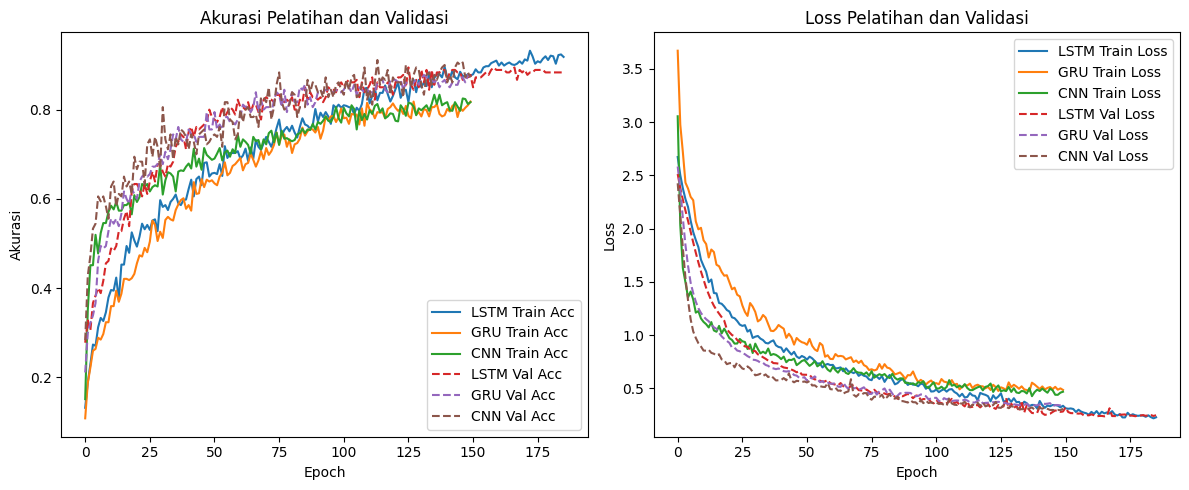

In [23]:
# --- 5. Pembangunan dan Pelatihan Model - Plot Hasil ---
print("\n--- Plotting Hasil Pelatihan ---")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['categorical_accuracy'], label='LSTM Train Acc')
plt.plot(history_gru.history['categorical_accuracy'], label='GRU Train Acc')
plt.plot(history_cnn.history['categorical_accuracy'], label='CNN Train Acc')
plt.plot(history_lstm.history['val_categorical_accuracy'], label='LSTM Val Acc', linestyle='--')
plt.plot(history_gru.history['val_categorical_accuracy'], label='GRU Val Acc', linestyle='--')
plt.plot(history_cnn.history['val_categorical_accuracy'], label='CNN Val Acc', linestyle='--')
plt.title("Akurasi Pelatihan dan Validasi")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='LSTM Train Loss')
plt.plot(history_gru.history['loss'], label='GRU Train Loss')
plt.plot(history_cnn.history['loss'], label='CNN Train Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Val Loss', linestyle='--')
plt.plot(history_gru.history['val_loss'], label='GRU Val Loss', linestyle='--')
plt.plot(history_cnn.history['val_loss'], label='CNN Val Loss', linestyle='--')
plt.title("Loss Pelatihan dan Validasi")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

## **b. Evaluasi Model**


--- Evaluasi Performa Model di Validation Set ---

=== Validation Performance ===


,acc,prec,f1
model,,,
LSTM,0.889,0.900,0.886
GRU,0.872,0.879,0.873
CNN,0.906,0.917,0.905



--- Classification Report untuk Model Terbaik (CNN) ---
                                         precision    recall  f1-score   support

        Angkat Pinggul - Tidak Bergerak       0.80      1.00      0.89        12
        Angkat Pinggul - Tidak Sempurna       1.00      1.00      1.00        12
              Angkat Pinggul - Sempurna       1.00      0.75      0.86        12
         Angkat Tangan - Tidak Bergerak       1.00      0.92      0.96        12
         Angkat Tangan - Tidak Sempurna       1.00      0.92      0.96        12
               Angkat Tangan - Sempurna       0.80      1.00      0.89        12
           Lutut Turun - Tidak Bergerak       1.00      0.67      0.80        12
           Lutut Turun - Tidak Sempurna       1.00      1.00      1.00        12
                 Lutut Turun - Sempurna       0.75      1.00      0.86        12
Naikan Kepalan Kedepan - Tidak Bergerak       0.83      0.83      0.83        12
Naikan Kepalan Kedepan - Tidak Sempurna       1.00 

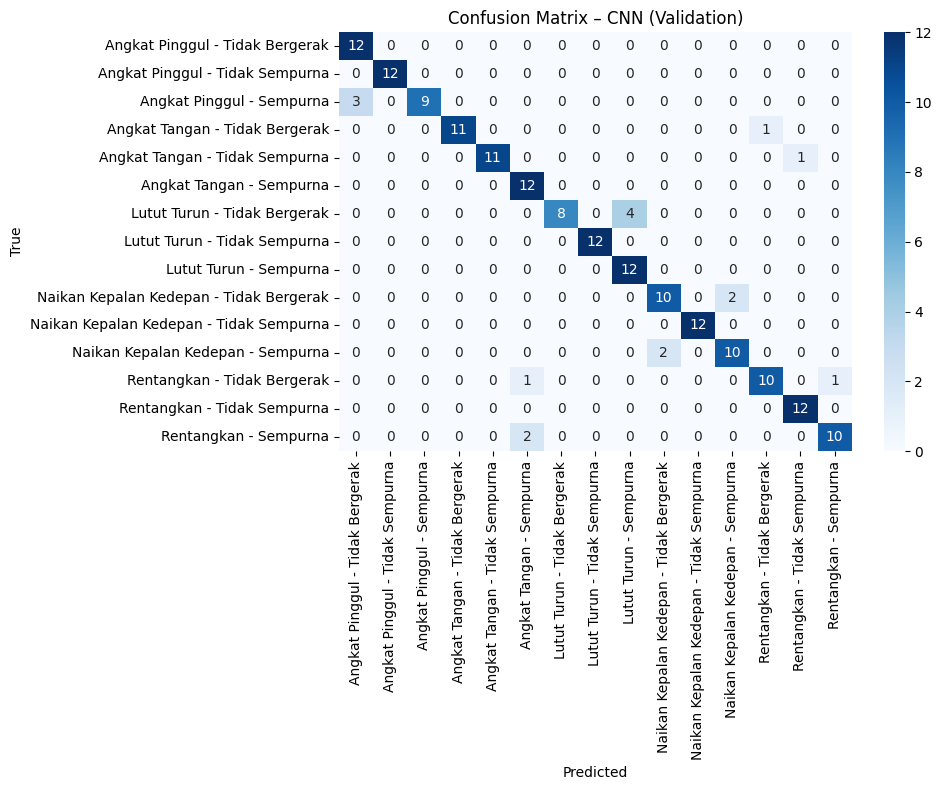


Folder keypoints_sublabeling_augmented telah dikompres menjadi keypoints_sublabeling_augmented.zip


In [24]:
# --- 6. Evaluasi Model ---
print("\n--- Evaluasi Performa Model di Validation Set ---")
def eval_val(model, X_data_scaled, y_true_one_hot):
    y_prob = model.predict(X_data_scaled, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = np.argmax(y_true_one_hot, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0)
    return acc, prec, rec, f1, y_true, y_pred

models_to_eval = {
    'LSTM': {'path': 'model_sublabeling/lstm_best.keras', 'data_scaled': X_val_scaled},
    'GRU': {'path': 'model_sublabeling/gru_best.keras', 'data_scaled': X_val_scaled},
    'CNN': {'path': 'model_sublabeling/cnn_best.keras', 'data_scaled': X_val_scaled}
}

scores = []
for name, config in models_to_eval.items():
    m = load_model(config['path'])
    acc, prec, rec, f1, _, _ = eval_val(m, config['data_scaled'], y_val_one_hot)
    scores.append(dict(model=name, acc=acc, prec=prec, f1=f1)) 

perf = pd.DataFrame(scores).set_index('model').round(3)
print('\n=== Validation Performance ===')
display(perf)

best_model_name = perf['f1'].idxmax()
best_model = load_model(models_to_eval[best_model_name]['path'])
acc, prec, rec, f1, y_true_val, y_pred_val = eval_val(best_model, models_to_eval[best_model_name]['data_scaled'], y_val_one_hot)

# Gunakan FULL_ACTIONS untuk target_names
print(f"\n--- Classification Report untuk Model Terbaik ({best_model_name}) ---")
print(classification_report(y_true_val, y_pred_val, target_names=FULL_ACTIONS, zero_division=0))

plt.figure(figsize=(10, 8)) # Ukuran plot disesuaikan karena lebih banyak kelas
cm = confusion_matrix(y_true_val, y_pred_val, labels=range(num_classes))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=FULL_ACTIONS, yticklabels=FULL_ACTIONS, cmap='Blues')
plt.title(f'Confusion Matrix – {best_model_name} (Validation)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90) # Rotasi label X agar tidak tumpang tindih
plt.yticks(rotation=0)  # Rotasi label Y
plt.tight_layout()
plt.show()

import shutil
# Buat folder untuk menyimpan model jika belum ada
os.makedirs('model_sublabeling', exist_ok=True)
# Kompres folder 'keypoints_sublabeling_augmented' menjadi 'keypoints_sublabeling_augmented.zip' jika belum ada
if not os.path.exists('keypoints_sublabeling_augmented.zip'):
    shutil.make_archive('keypoints_sublabeling_augmented', 'zip', 'keypoints_sublabeling_augmented')
    print("\nFolder keypoints_sublabeling_augmented telah dikompres menjadi keypoints_sublabeling_augmented.zip")

# **6. Inferensi Model**

## **a. Inferensi Klasifikasi Gerakan**

In [ ]:
# --- 7. Inferensi Model - a. Inferensi Klasifikasi Gerakan ---
print("\n--- Inferensi Model - Klasifikasi Gerakan (dengan Sub-label) ---")

SEQ_LEN       = 60 # DIUBAH DARI 30 MENJADI 60
DETECT_THRESH = 0.7
LABELS = np.array(FULL_ACTIONS) # Gunakan FULL_ACTIONS sebagai label inferensi

inference_model = load_model(models_to_eval[best_model_name]['path']) 
pose_model = YOLO('yolov8n-pose.pt')

buf = deque(maxlen=SEQ_LEN)

def extract_and_normalize_keypoints_inference(results, frame_shape):
    num_kpts_features = 17 * 2
    keypoints_flat = np.zeros(num_kpts_features, dtype='float32')

    if results is not None and len(results.keypoints.xy) > 0:
        kps = results.keypoints.xy[0].cpu().numpy()  
        
        if kps.shape[0] == 17:
            h, w, _ = frame_shape
            normalized_kps = kps / np.array([w, h])
            keypoints_flat = normalized_kps.flatten()
    
    return keypoints_flat.astype('float32')

print("Memulai inferensi klasifikasi gerakan. Tekan 'ESC' untuk keluar.")
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results_yolo = pose_model.predict(frame, verbose=False)
    
    keypoints_current_frame = extract_and_normalize_keypoints_inference(results_yolo[0], frame.shape)
    buf.append(keypoints_current_frame)

    pred_label = "Menunggu Gerakan..."
    last_conf = 0.0

    if len(buf) == SEQ_LEN:
        seq_input = np.array(buf).reshape(1, SEQ_LEN, keypoints_current_frame.shape[0])
        
        seq_input_flat = seq_input.reshape(-1, keypoints_current_frame.shape[0])
        seq_input_scaled = scaler.transform(seq_input_flat).reshape(1, SEQ_LEN, keypoints_current_frame.shape[0])
        
        prediction_probs = inference_model.predict(seq_input_scaled, verbose=0)[0] 
        idx_pred = int(np.argmax(prediction_probs))
        last_conf = float(probs[idx_pred])
        pred_label = LABELS[idx_pred] # Prediksi langsung sub-label

        if last_conf < DETECT_THRESH:
            pred_label = "Tidak Yakin"

    text = f"Pose: {pred_label} ({last_conf*100:.1f}%)"
    cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 255, 0) if last_conf > DETECT_THRESH else (0, 0, 255), 2)

    if results_yolo[0].keypoints is not None and len(results_yolo[0].keypoints.xy) > 0:
        annotated_frame = results_yolo[0].plot()
        cv2.imshow('YOLOv8 Pose + Model Klasifikasi', annotated_frame)
    else:
        cv2.imshow('YOLOv8 Pose + Model Klasifikasi', frame)

    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()


--- Inferensi Model - Klasifikasi Gerakan (dengan Sub-label) ---
Memulai inferensi klasifikasi gerakan. Tekan 'ESC' untuk keluar.


NameError: name 'probs' is not defined

: 

## **b. Inferensi Lanjutan**

In [ ]:
# --- 7. Inferensi Model - b. Inferensi Lanjutan (Asisten Rehabilitasi) ---
print("\n--- Inferensi Model - Asisten Rehabilitasi (Disesuaikan untuk Sub-label Model) ---")

LABELS_WORKFLOW = np.array(FULL_ACTIONS) # Menggunakan FULL_ACTIONS
WORKFLOW = np.array(BASE_ACTIONS) # Workflow tetap berdasarkan aksi utama

SEQ_LEN = 60 # DIUBAH DARI 30 MENJADI 60
DETECT_THRESH_MAIN_MODEL = 0.70

# Ambang batas progres ini mungkin tidak lagi relevan jika model memprediksi stage langsung
THRESHOLD_PARTIAL = 0.30
THRESHOLD_GOOD = 0.70

CONFIRMATION_FRAMES_COMPLETE = 10
INACTIVITY_FRAMES_RESET = 30
EXER_TIME = 20 # Durasi per latihan dalam detik (contoh)
POPUP_TIME = 3 # Durasi popup dalam detik (contoh)

FONT = cv2.FONT_HERSHEY_SIMPLEX

inference_model_workflow = load_model(models_to_eval[best_model_name]['path']) 
pose_model_workflow = YOLO('yolov8n-pose.pt')

# Fungsi calculate_movement_progress_for_display mungkin masih berguna untuk menampilkan progres kontinu
# meskipun model memprediksi stage diskrit.
def calculate_movement_progress_for_display(current_kps_normalized, base_action_name, calibration_params):
    progress = 0.0
    if base_action_name == "Angkat Tangan":
        wrist_y_avg = (current_kps_normalized[9][1] + current_kps_normalized[10][1]) / 2
        min_y = calibration_params.get('min_y_wrist_at_100', 0.1) 
        max_y = calibration_params.get('max_y_wrist_at_0', 0.7)   
        if (max_y - min_y) > 0:
            progress = (max_y - wrist_y_avg) / (max_y - min_y)
        else:
            progress = 0.0
    elif base_action_name == "Angkat Pinggul":
        hip_y_avg = (current_kps_normalized[11][1] + current_kps_normalized[12][1]) / 2
        min_y = calibration_params.get('min_y_hip_at_100', 0.6) 
        max_y = calibration_params.get('max_y_hip_at_0', 0.8)   
        if (max_y - min_y) > 0:
            progress = (max_y - hip_y_avg) / (max_y - min_y)
        else:
            progress = 0.0
    elif base_action_name == "Rentangkan":
        hip_x_avg = (current_kps_normalized[11][0] + current_kps_normalized[12][0]) / 2
        dist_right_arm_x = current_kps_normalized[10][0] - hip_x_avg
        dist_left_arm_x = hip_x_avg - current_kps_normalized[9][0] # Perbaikan: current_kps_normalized[9][0]
        max_abs_dist_x = max(dist_right_arm_x, dist_left_arm_x)

        min_x = calibration_params.get('min_x_stretch_observed', 0.05)
        max_x = calibration_params.get('max_x_stretch_observed', 0.35)
        
        if (max_x - min_x) > 0:
            progress = (max_abs_dist_x - min_x) / (max_x - min_x)
        else:
            progress = 0.0
    return np.clip(progress, 0.0, 1.0)

# Parameter Kalibrasi Gerakan (tetap sama)
CALIBRATION_PARAMS = {
    "Angkat Tangan": {
        'min_y_wrist_at_100': 0.1, 
        'max_y_wrist_at_0': 0.7    
    },
    "Angkat Pinggul": {
        'min_y_hip_at_100': 0.6,   
        'max_y_hip_at_0': 0.8      
    },
    "Rentangkan": {
        'min_x_stretch_observed': 0.05,
        'max_x_stretch_observed': 0.35  
    },
    "Lutut Turun": {},
    "Naikan Kepalan Kedepan": {}
}

# --- Inisialisasi State Machine ---
current_base_action = "Idle" 
current_predicted_substage = "Menunggu Gerakan..." 
main_action_counter = 0 
substage_confirm_counter = 0 
frames_since_last_overall_detection = 0 

keypoint_sequence_buffer_workflow = deque(maxlen=SEQ_LEN)

idx_workflow_step = 0
t_ex_start = time.time()
popup_phase = None
popup_start = None
score_workflow = {w: None for w in WORKFLOW}

print("Memulai Asisten Rehabilitasi. Tekan 'ESC' untuk keluar.")
cap = cv2.VideoCapture(0)

while cap.isOpened() and idx_workflow_step < len(WORKFLOW):
    ok, frame = cap.read()
    if not ok:
        break

    results_yolo = pose_model_workflow.predict(frame, verbose=False)
    bgr = frame.copy()

    keypoints_current_frame = extract_and_normalize_keypoints_inference(results_yolo[0], frame.shape)
    keypoint_sequence_buffer_workflow.append(keypoints_current_frame)

    predicted_full_label = "None"
    predicted_base_action = "None"
    predicted_sub_label = "None"
    prediction_confidence = 0.0
    
    if len(keypoint_sequence_buffer_workflow) == SEQ_LEN and popup_phase is None:
        seq_input = np.array(keypoint_sequence_buffer_workflow).reshape(1, SEQ_LEN, keypoints_current_frame.shape[0])
        
        seq_input_flat = seq_input.reshape(-1, keypoints_current_frame.shape[0])
        seq_input_scaled = scaler.transform(seq_input_flat).reshape(1, SEQ_LEN, keypoints_current_frame.shape[0])
        
        prediction_probs = inference_model_workflow.predict(seq_input_scaled, verbose=0)
        predicted_full_label_idx = np.argmax(prediction_probs)
        prediction_confidence = np.max(prediction_probs)
        
        if prediction_confidence >= DETECT_THRESH_MAIN_MODEL:
            predicted_full_label = LABELS_WORKFLOW[predicted_full_label_idx]
            parts = predicted_full_label.split(' - ')
            if len(parts) == 2:
                predicted_base_action = parts[0]
                predicted_sub_label = parts[1]
            else:
                predicted_base_action = predicted_full_label
                predicted_sub_label = "Tidak Diketahui"

    pop_up_message = ""
    target_base_action = WORKFLOW[idx_workflow_step]

    if popup_phase is None:
        
        remaining_time = EXER_TIME - int(time.time() - t_ex_start)
        if remaining_time <= 0:
            pop_up_message = f"*** POP-UP: Gerakan '{target_base_action}' Gagal (Waktu Habis)! ***"
            score_workflow[target_base_action] = False
            popup_phase = 'result'
            remaining_time = 0

        elif predicted_base_action == target_base_action:
            frames_since_last_overall_detection = 0
            current_base_action = target_base_action

            # Langsung gunakan prediksi sub-label dari model
            current_predicted_substage = predicted_sub_label

            if current_predicted_substage == "Sempurna":
                substage_confirm_counter += 1
                pop_up_message = f"'{target_base_action}': Gerakan Sempurna ({int(prediction_confidence*100)}%)"
            else:
                substage_confirm_counter = 0
                pop_up_message = f"'{target_base_action}': Gerakan {current_predicted_substage} ({int(prediction_confidence*100)}%)"

            if current_predicted_substage == "Sempurna" and substage_confirm_counter >= CONFIRMATION_FRAMES_COMPLETE:
                pop_up_message = f"*** POP-UP: Gerakan '{target_base_action}' Berhasil Diselesaikan dengan Sempurna! ***"
                score_workflow[target_base_action] = True
                popup_phase = 'result'

        else:
            frames_since_last_overall_detection += 1
            if current_base_action != "Idle" and frames_since_last_overall_detection >= INACTIVITY_FRAMES_RESET:
                pop_up_message = f"*** POP-UP: Gerakan '{target_base_action}' Gagal (Tidak Ada Gerakan Terdeteksi)! ***"
                score_workflow[target_base_action] = False
                popup_phase = 'result'
                frames_since_last_overall_detection = 0
            elif current_base_action == "Idle":
                pop_up_message = "Menunggu Gerakan..."

        cv2.rectangle(bgr, (0, 0), (640, 60), (0, 0, 0), -1)
        cv2.putText(bgr,
                    f'Aksi Target: {target_base_action}   |   Timer: {remaining_time:02d}s',
                    (10, 25), FONT, 0.6, (255, 255, 255), 2)

        det_txt = f"Deteksi Model: '{predicted_full_label}' ({prediction_confidence*100:4.1f}%)"
        cv2.putText(bgr, det_txt, (10, 50), FONT, 0.6, (0, 255, 255), 2)

        cv2.rectangle(bgr, (0, 440), (640, 480), (0, 0, 0), -1)
        cv2.putText(bgr, f'Status Workflow: {current_predicted_substage}', (10, 470), FONT, 0.7, (0, 255, 255), 2)
        
        if results_yolo[0].keypoints is not None and len(results_yolo[0].keypoints.xy) > 0:
            annotated_frame = results_yolo[0].plot()
            bgr = annotated_frame
        
        cv2.imshow('Rehab-Assist', bgr)
        key = cv2.waitKey(1) & 0xFF
        if key == 27:
            break

    if popup_phase is not None:
        key = cv2.waitKey(10) & 0xFF
        
        if popup_phase == 'result':
            cv2.rectangle(bgr, (40, 140), (600, 270), (0, 0, 0), -1)
            cv2.putText(bgr,
                        f"Gerakan '{target_base_action}' : " + ('BERHASIL' if score_workflow[target_base_action] else 'GAGAL'),
                        (60, 190), FONT, 0.8, (255, 255, 255), 2)

            if idx_workflow_step + 1 < len(WORKFLOW):
                cv2.putText(bgr, 'Tekan ENTER untuk lanjut',
                            (60, 230), FONT, 0.7, (0, 255, 255), 2)
            else:
                cv2.putText(bgr, 'Sesi selesai, tekan ESC untuk keluar',
                            (60, 230), FONT, 0.7, (0, 255, 255), 2)

            cv2.imshow('Rehab-Assist', bgr)
            if key in (13, 10):
                popup_phase = 'prep'
                popup_start = time.time()
                current_base_action = "Idle"
                current_predicted_substage = "Menunggu Gerakan..."
                main_action_counter = 0
                substage_confirm_counter = 0
                frames_since_last_overall_detection = 0
                keypoint_sequence_buffer_workflow.clear()

        elif popup_phase == 'prep':
            elap = time.time() - popup_start
            cnt = POPUP_TIME - int(elap)

            cv2.rectangle(bgr, (40, 140), (600, 270), (0, 0, 0), -1)
            cv2.putText(bgr, f"Siapkan gerakan : '{WORKFLOW[idx_workflow_step+1]}'",
                        (60, 190), FONT, 0.7, (255, 255, 255), 2)
            cv2.putText(bgr, f"Mulai dalam {cnt:02d} dtk",
                        (60, 230), FONT, 0.9, (0, 255, 255), 2)

            cv2.imshow('Rehab-Assist', bgr)
            if elap >= POPUP_TIME:
                idx_workflow_step += 1
                t_ex_start = time.time()
                popup_phase = None

        if key == 27:
            break

cap.release()
cv2.destroyAllWindows()




In [ ]:
# --- 7. Inferensi Model - b. Inferensi Lanjutan (Skor Akhir) ---
print('\n--- Skor Akhir Sesi Rehabilitasi ---')
for act in WORKFLOW:
    status = "✓" if score_workflow.get(act) else "✗"
    print(f'{act:<25}: {status}')

Skor akhir:
Angkat Tangan            : ✗
